In [1]:
#%pip install -r ../requeriments.txt --quiet

# **Pix2Pix Loss Function Comparison - Notebook Outline**

## **1. Introduction and Setup**

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
import torchvision.models as models


import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import random
from tqdm import tqdm
import time
import csv
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"CUDA Version: {torch.version.cuda}")

# Project configuration
class Config:
    # Dataset paths
    DATA_DIR = "../data"
    TRAIN_DIR = os.path.join(DATA_DIR, "train")
    VAL_DIR = os.path.join(DATA_DIR, "val")
    
    # Training parameters
    BATCH_SIZE = 16
    NUM_WORKERS = 2
    IMAGE_SIZE = 192 
    CHANNELS_IMG = 3
    LEARNING_RATE = 2e-4
    BETA1 = 0.5
    BETA2 = 0.999
    
    # Loss function parameters
    L1_LAMBDA = 100
    PERCEPTUAL_LAMBDA = 10
    TV_LAMBDA = 0.1
    
    # Training settings
    NUM_EPOCHS = 60
    SAMPLE_INTERVAL = 10
    CHECKPOINT_INTERVAL = 10
    MAX_DATASET_SIZE = 10000 
    
    # Results directories
    RESULTS_DIR = "results"
    GENERATED_SAMPLES_DIR = os.path.join(RESULTS_DIR, "generated_samples")
    SUMMARY_IMG_DIR = os.path.join(RESULTS_DIR, "summary", "img_reports")
    SUMMARY_CSV_DIR = os.path.join(RESULTS_DIR, "summary", "csv")
    
    # Model checkpoints
    CHECKPOINT_DIR = "checkpoints"
    
    # Device
    DEVICE = device

# Create folders
def create_directories():
    """Create all necessary directories for the project"""
    dirs = [
        Config.RESULTS_DIR,
        Config.GENERATED_SAMPLES_DIR,
        Config.SUMMARY_IMG_DIR,
        Config.SUMMARY_CSV_DIR,
        Config.CHECKPOINT_DIR
    ]
    
    for dir_path in dirs:
        os.makedirs(dir_path, exist_ok=True)
    print("Created project directories")

create_directories()

# Set seeds
def set_seed(seed=42):
    """Set random seeds for reproducible results"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(30082025)

# Data transformations
transform_both = transforms.Compose([
    transforms.Resize((Config.IMAGE_SIZE, Config.IMAGE_SIZE)),
])

transform_input = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_target = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Utility functions
def denormalize(tensor):
    """[-1, 1] to [0, 1]"""
    return tensor * 0.5 + 0.5

def save_sample_images(generator, val_loader, epoch, folder, num_samples=4):
    generator.eval()
    with torch.no_grad():
        batch_sketch, batch_real = next(iter(val_loader))
        batch_sketch = batch_sketch[:num_samples].to(Config.DEVICE)
        batch_real = batch_real[:num_samples].to(Config.DEVICE)
        
        generated = generator(batch_sketch)
        
        # Denormalize
        sketch_imgs = denormalize(batch_sketch)
        real_imgs = denormalize(batch_real)
        gen_imgs = denormalize(generated)
        
        # Comparison grid
        comparison = torch.cat([sketch_imgs, real_imgs, gen_imgs], dim=0)
        save_image(comparison, 
                  os.path.join(folder, f"epoch_{epoch:03d}.png"), 
                  nrow=num_samples, normalize=False)
    
    generator.train()

def get_gpu_memory():
    """Get current GPU memory usage"""
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / 1024**3  # GB
    return 0

def log_metrics(metrics_dict, csv_path):
    """Log metrics to CSV file"""
    file_exists = os.path.isfile(csv_path)
    with open(csv_path, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=metrics_dict.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(metrics_dict)

print("=" * 60)
print("PIX2PIX LOSS FUNCTION COMPARISON")
print("Anime Sketch Colorization Pair Dataset")
print("=" * 60)
print(f"Configuration:")
print(f"- Image Size: {Config.IMAGE_SIZE}x{Config.IMAGE_SIZE}")
print(f"- Batch Size: {Config.BATCH_SIZE}")
print(f"- Max Dataset Size: {Config.MAX_DATASET_SIZE}")
print(f"- Training Epochs: {Config.NUM_EPOCHS}")
print(f"- Device: {Config.DEVICE}")
print("=" * 60)

Using device: cpu
Created project directories
PIX2PIX LOSS FUNCTION COMPARISON
Anime Sketch Colorization Pair Dataset
Configuration:
- Image Size: 192x192
- Batch Size: 16
- Max Dataset Size: 10000
- Training Epochs: 60
- Device: cpu


## **2. Dataset Loading and Preprocessing**

Creating datasets with 8000 train and 2000 val images
Found 8000 images in ../data/train
Found 2000 images in ../data/val
Train loader: 500 batches
Val loader: 125 batches
Dataset samples saved to results/summary/img_reports/dataset_samples.png


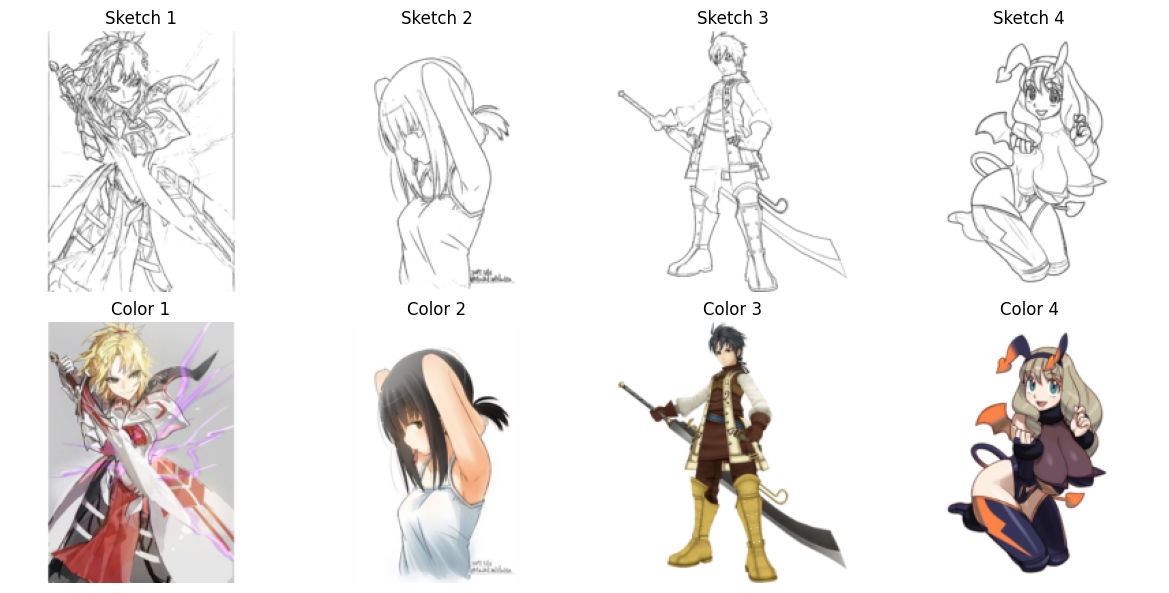

Dataset statistics:
- Training batches: 500
- Validation batches: 125
- Image resolution: 192x192
- Batch size: 16


In [3]:
import glob

class AnimeSketchDataset(Dataset):
    def __init__(self, root_dir, max_size=None, is_train=True):
        self.root_dir = root_dir
        self.is_train = is_train
        self.image_files = []

        # Get img
        for ext in ['*.png', '*.jpg', '*.jpeg']:
            self.image_files.extend(glob.glob(os.path.join(root_dir, ext)))
        
        # Limit dataset size
        if max_size and len(self.image_files) > max_size:
            self.image_files = random.sample(self.image_files, max_size)
        
        print(f"Found {len(self.image_files)} images in {root_dir}")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        
        # Load the combined image
        image = Image.open(img_path).convert('RGB')
        w, h = image.size
        
        # Split the image (Left/right)
        color_img = image.crop((0, 0, w // 2, h))
        sketch_img = image.crop((w // 2, 0, w, h))
        
        # Size transformations
        color_img = transform_both(color_img)
        sketch_img = transform_both(sketch_img)
        
        if self.is_train:
            seed = random.randint(0, 2**32)
            
            # Transform sketch (input)
            random.seed(seed)
            torch.manual_seed(seed)
            sketch_tensor = transform_input(sketch_img)
            
            # Transform color (target) - no augmentation
            color_tensor = transform_target(color_img)
        else:
            # No augmentation for validation
            sketch_tensor = transform_val(sketch_img)
            color_tensor = transform_val(color_img)
        
        return sketch_tensor, color_tensor

def create_data_loaders():
    """Create train and validation data loaders"""
    
    train_size = int(Config.MAX_DATASET_SIZE * 0.8)  # 80% for training
    val_size = Config.MAX_DATASET_SIZE - train_size   # 20% for validation
    
    print(f"Creating datasets with {train_size} train and {val_size} val images")
    
    # Create datasets
    train_dataset = AnimeSketchDataset(
        Config.TRAIN_DIR, 
        max_size=train_size, 
        is_train=True
    )
    
    val_dataset = AnimeSketchDataset(
        Config.VAL_DIR, 
        max_size=val_size, 
        is_train=False
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True if Config.DEVICE.type == 'cuda' else False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True if Config.DEVICE.type == 'cuda' else False
    )
    
    print(f"Train loader: {len(train_loader)} batches")
    print(f"Val loader: {len(val_loader)} batches")
    
    return train_loader, val_loader

def visualize_dataset_samples(data_loader, num_samples=4, save_path=None):
    """Visualize dataset samples"""
    data_iter = iter(data_loader)
    sketch_batch, color_batch = next(data_iter)
    
    # Few samples
    sketches = sketch_batch[:num_samples]
    colors = color_batch[:num_samples]
    
    # Den for visualization
    sketches = denormalize(sketches)
    colors = denormalize(colors)
    
    # Visualization
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 3, 6))
    
    for i in range(num_samples):
        # Top
        sketch_np = sketches[i].permute(1, 2, 0).cpu().numpy()
        axes[0, i].imshow(sketch_np)
        axes[0, i].set_title(f'Sketch {i+1}')
        axes[0, i].axis('off')
        
        # Bottom
        color_np = colors[i].permute(1, 2, 0).cpu().numpy()
        axes[1, i].imshow(color_np)
        axes[1, i].set_title(f'Color {i+1}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Dataset samples saved to {save_path}")
    
    plt.show()

# Create the data loaders
train_loader, val_loader = create_data_loaders()

# Some samples
sample_viz_path = os.path.join(Config.SUMMARY_IMG_DIR, "dataset_samples.png")
visualize_dataset_samples(val_loader, num_samples=4, save_path=sample_viz_path)

print(f"Dataset statistics:")
print(f"- Training batches: {len(train_loader)}")
print(f"- Validation batches: {len(val_loader)}")
print(f"- Image resolution: {Config.IMAGE_SIZE}x{Config.IMAGE_SIZE}")
print(f"- Batch size: {Config.BATCH_SIZE}")

## **3. Model Architecture Implementation**

In [6]:
class ConvBlock(nn.Module):
    """Convolutional block for encoder"""
    def __init__(self, in_channels, out_channels, down=True, use_bn=True, use_dropout=False):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False) if down else \
                   nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels) if use_bn else None
        self.dropout = nn.Dropout(0.5) if use_dropout else None
        self.activation = nn.LeakyReLU(0.2) if down else nn.ReLU()
    
    def forward(self, x):
        x = self.conv(x)
        if self.bn:
            x = self.bn(x)
        if self.dropout:
            x = self.dropout(x)
        return self.activation(x)

class Generator(nn.Module):
    """U-Net Generator"""
    def __init__(self, in_channels=3, out_channels=3, features=64):
        super().__init__()
        
        # Encoder (downsampling)
        self.down1 = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode='reflect'),
            nn.LeakyReLU(0.2)
        )
        self.down2 = ConvBlock(features, features * 2, down=True, use_bn=True)
        self.down3 = ConvBlock(features * 2, features * 4, down=True, use_bn=True)
        self.down4 = ConvBlock(features * 4, features * 8, down=True, use_bn=True)
        self.down5 = ConvBlock(features * 8, features * 8, down=True, use_bn=True)
        self.down6 = ConvBlock(features * 8, features * 8, down=True, use_bn=True)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1, padding_mode='reflect'),
            nn.ReLU()
        )
        
        # Decoder (upsampling) with skip connections
        self.up1 = ConvBlock(features * 8, features * 8, down=False, use_bn=True, use_dropout=True)
        self.up2 = ConvBlock(features * 8 * 2, features * 8, down=False, use_bn=True, use_dropout=True)
        self.up3 = ConvBlock(features * 8 * 2, features * 8, down=False, use_bn=True, use_dropout=True)
        self.up4 = ConvBlock(features * 8 * 2, features * 4, down=False, use_bn=True)
        self.up5 = ConvBlock(features * 4 * 2, features * 2, down=False, use_bn=True)
        self.up6 = ConvBlock(features * 2 * 2, features, down=False, use_bn=True)
        
        # Final layer
        self.final = nn.Sequential(
            nn.ConvTranspose2d(features * 2, out_channels, 4, 2, 1),
            nn.Tanh()
        )
    
    def forward(self, x):
        # Encoder with skip connections
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        
        # Bottleneck
        bottleneck = self.bottleneck(d6)
        
        # Decoder with skip connections
        u1 = self.up1(bottleneck)
        # Ensure spatial dimensions match
        if u1.shape[2:] != d6.shape[2:]:
            u1 = nn.functional.interpolate(u1, size=d6.shape[2:], mode='bilinear', align_corners=False)
        u2 = self.up2(torch.cat([u1, d6], dim=1))
        
        if u2.shape[2:] != d5.shape[2:]:
            u2 = nn.functional.interpolate(u2, size=d5.shape[2:], mode='bilinear', align_corners=False)
        u3 = self.up3(torch.cat([u2, d5], dim=1))
        
        if u3.shape[2:] != d4.shape[2:]:
            u3 = nn.functional.interpolate(u3, size=d4.shape[2:], mode='bilinear', align_corners=False)
        u4 = self.up4(torch.cat([u3, d4], dim=1))
        
        if u4.shape[2:] != d3.shape[2:]:
            u4 = nn.functional.interpolate(u4, size=d3.shape[2:], mode='bilinear', align_corners=False)
        u5 = self.up5(torch.cat([u4, d3], dim=1))
        
        if u5.shape[2:] != d2.shape[2:]:
            u5 = nn.functional.interpolate(u5, size=d2.shape[2:], mode='bilinear', align_corners=False)
        u6 = self.up6(torch.cat([u5, d2], dim=1))
        
        if u6.shape[2:] != d1.shape[2:]:
            u6 = nn.functional.interpolate(u6, size=d1.shape[2:], mode='bilinear', align_corners=False)
        
        return self.final(torch.cat([u6, d1], dim=1))

class Discriminator(nn.Module):
    """PatchGAN Discriminator"""
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        
        # Input: concatenated sketch and target/generated
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels * 2, features, 4, 2, 1, padding_mode='reflect'),
            nn.LeakyReLU(0.2)
        )
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(features, features * 2, 4, 2, 1, bias=False, padding_mode='reflect'),
            nn.BatchNorm2d(features * 2),
            nn.LeakyReLU(0.2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(features * 2, features * 4, 4, 2, 1, bias=False, padding_mode='reflect'),
            nn.BatchNorm2d(features * 4),
            nn.LeakyReLU(0.2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(features * 4, features * 8, 4, 1, 1, bias=False, padding_mode='reflect'),
            nn.BatchNorm2d(features * 8),
            nn.LeakyReLU(0.2)
        )
        
        # Final layer
        self.final = nn.Conv2d(features * 8, 1, 4, 1, 1, padding_mode='reflect')
    
    def forward(self, sketch, target):
        x = torch.cat([sketch, target], dim=1)
        x = self.initial(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return self.final(x)

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.constant_(m.bias, 0)

def create_models():
    generator = Generator(
        in_channels=Config.CHANNELS_IMG,
        out_channels=Config.CHANNELS_IMG,
        features=64
    ).to(Config.DEVICE)
    
    discriminator = Discriminator(
        in_channels=Config.CHANNELS_IMG,
        features=64
    ).to(Config.DEVICE)
    
    # Initialize weights
    initialize_weights(generator)
    initialize_weights(discriminator)
    
    # Print model info
    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    gen_params = count_parameters(generator)
    disc_params = count_parameters(discriminator)
    
    print(f"Generator parameters: {gen_params:,}")
    print(f"Discriminator parameters: {disc_params:,}")
    print(f"Total parameters: {gen_params + disc_params:,}")
    
    return generator, discriminator

def test_models():

    batch_size = 2
    dummy_sketch = torch.randn(batch_size, 3, Config.IMAGE_SIZE, Config.IMAGE_SIZE).to(Config.DEVICE)
    dummy_color = torch.randn(batch_size, 3, Config.IMAGE_SIZE, Config.IMAGE_SIZE).to(Config.DEVICE)
    
    # Test generator
    gen = Generator().to(Config.DEVICE)
    gen_output = gen(dummy_sketch)
    print(f"Generator input shape: {dummy_sketch.shape}")
    print(f"Generator output shape: {gen_output.shape}")
    
    # Test discriminator
    disc = Discriminator().to(Config.DEVICE)
    disc_output = disc(dummy_sketch, dummy_color)
    print(f"Discriminator inputs shape: {dummy_sketch.shape}, {dummy_color.shape}")
    print(f"Discriminator output shape: {disc_output.shape}")
    
    # Cleanup
    del gen, disc, dummy_sketch, dummy_color, gen_output, disc_output
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    

# Create the models
generator, discriminator = create_models()

# Test model architectures
test_models()

print(f"Models created and moved to {Config.DEVICE}")

Generator parameters: 41,829,571
Discriminator parameters: 2,768,705
Total parameters: 44,598,276
Generator input shape: torch.Size([2, 3, 192, 192])
Generator output shape: torch.Size([2, 3, 192, 192])
Discriminator inputs shape: torch.Size([2, 3, 192, 192]), torch.Size([2, 3, 192, 192])
Discriminator output shape: torch.Size([2, 1, 22, 22])
Models created and moved to cpu


## **4. Loss Functions Implementation**

In [7]:
class VGGPerceptualLoss(nn.Module):
    def __init__(self, layer_weights=None):
        super().__init__()
        # Pre-trained VGG19
        vgg = models.vgg19(pretrained=True).features
        self.vgg_layers = nn.ModuleList()

        layer_indices = [1, 6, 11, 20, 29]
        
        current_layer = 0
        temp_seq = nn.Sequential()
        
        for i, layer in enumerate(vgg):
            temp_seq.add_module(str(i), layer)
            if i in layer_indices:
                self.vgg_layers.append(temp_seq)
                temp_seq = nn.Sequential()
        
        for param in self.parameters():
            param.requires_grad = False
        
        # Layer weights for combining
        self.layer_weights = layer_weights or [1.0, 1.0, 1.0, 1.0, 1.0]
    
    def forward(self, pred, target):
        pred = (pred + 1) / 2
        target = (target + 1) / 2
        
        if pred.shape[1] == 1:
            pred = pred.repeat(1, 3, 1, 1)
        if target.shape[1] == 1:
            target = target.repeat(1, 3, 1, 1)
        
        loss = 0
        pred_features = pred
        target_features = target
        
        for i, layer in enumerate(self.vgg_layers):
            pred_features = layer(pred_features)
            target_features = layer(target_features)
            
            # L2 loss between feature maps
            layer_loss = nn.functional.mse_loss(pred_features, target_features)
            loss += self.layer_weights[i] * layer_loss
        
        return loss

class TotalVariationLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        # Calculate differences in horizontal and vertical directions
        diff_h = torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :])
        diff_w = torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:])
        
        # Sum over all dimensions except batch
        tv_loss = torch.mean(diff_h) + torch.mean(diff_w)
        return tv_loss

class LossFunctions:
    def __init__(self, device):
        self.device = device
        
        # Basic losses
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.l1_loss = nn.L1Loss()
        self.mse_loss = nn.MSELoss()
        
        # Other losses
        self.perceptual_loss = VGGPerceptualLoss().to(device)
        self.tv_loss = TotalVariationLoss()
    
    def discriminator_loss(self, real_pred, fake_pred):
        """Standard discriminator loss"""
        real_loss = self.bce_loss(real_pred, torch.ones_like(real_pred))
        fake_loss = self.bce_loss(fake_pred, torch.zeros_like(fake_pred))
        return (real_loss + fake_loss) / 2
    
    def generator_loss_standard(self, fake_pred, fake_img, real_img, l1_lambda=100):
        """Standard Pix2Pix loss: BCE + L1"""
        # Adversarial loss
        adv_loss = self.bce_loss(fake_pred, torch.ones_like(fake_pred))
        
        # L1 reconstruction loss
        l1_loss = self.l1_loss(fake_img, real_img)
        
        return adv_loss + l1_lambda * l1_loss, {
            'adv_loss': adv_loss.item(),
            'l1_loss': l1_loss.item()
        }
    
    def generator_loss_perceptual(self, fake_pred, fake_img, real_img, 
                                l1_lambda=100, perceptual_lambda=10):
        """Perceptual Pix2Pix loss: BCE + L1 + VGG"""
        # Adversarial loss
        adv_loss = self.bce_loss(fake_pred, torch.ones_like(fake_pred))
        
        # L1 reconstruction loss
        l1_loss = self.l1_loss(fake_img, real_img)
        
        # Perceptual loss
        perc_loss = self.perceptual_loss(fake_img, real_img)
        
        total_loss = adv_loss + l1_lambda * l1_loss + perceptual_lambda * perc_loss
        
        return total_loss, {
            'adv_loss': adv_loss.item(),
            'l1_loss': l1_loss.item(),
            'perceptual_loss': perc_loss.item()
        }
    
    def generator_loss_regularized(self, fake_pred, fake_img, real_img, 
                                 l1_lambda=100, tv_lambda=0.1):
        """Regularized Pix2Pix loss: BCE + L1 + Total Variation"""
        # Adversarial loss
        adv_loss = self.bce_loss(fake_pred, torch.ones_like(fake_pred))
        
        # L1 reconstruction loss
        l1_loss = self.l1_loss(fake_img, real_img)
        
        # Total variation loss for smoothness
        tv_loss = self.tv_loss(fake_img)
        
        total_loss = adv_loss + l1_lambda * l1_loss + tv_lambda * tv_loss
        
        return total_loss, {
            'adv_loss': adv_loss.item(),
            'l1_loss': l1_loss.item(),
            'tv_loss': tv_loss.item()
        }

def test_loss_functions():
    batch_size = 2
    dummy_real = torch.randn(batch_size, 3, Config.IMAGE_SIZE, Config.IMAGE_SIZE).to(Config.DEVICE)
    dummy_fake = torch.randn(batch_size, 3, Config.IMAGE_SIZE, Config.IMAGE_SIZE).to(Config.DEVICE)
    dummy_disc_pred = torch.randn(batch_size, 1, 16, 16).to(Config.DEVICE)  # PatchGAN output
    
    # Initialize loss functions
    loss_fn = LossFunctions(Config.DEVICE)
    
    # Test discriminator loss
    disc_loss = loss_fn.discriminator_loss(dummy_disc_pred, dummy_disc_pred)
    print(f"Discriminator loss: {disc_loss.item():.4f}")
    
    # Test standard generator loss
    gen_loss_std, metrics_std = loss_fn.generator_loss_standard(
        dummy_disc_pred, dummy_fake, dummy_real
    )
    print(f"Standard generator loss: {gen_loss_std.item():.4f}")
    print(f"  - Adversarial: {metrics_std['adv_loss']:.4f}")
    print(f"  - L1: {metrics_std['l1_loss']:.4f}")
    
    # Test perceptual generator loss
    gen_loss_perc, metrics_perc = loss_fn.generator_loss_perceptual(
        dummy_disc_pred, dummy_fake, dummy_real
    )
    print(f"Perceptual generator loss: {gen_loss_perc.item():.4f}")
    print(f"  - Adversarial: {metrics_perc['adv_loss']:.4f}")
    print(f"  - L1: {metrics_perc['l1_loss']:.4f}")
    print(f"  - Perceptual: {metrics_perc['perceptual_loss']:.4f}")
    
    # Test regularized generator loss
    gen_loss_reg, metrics_reg = loss_fn.generator_loss_regularized(
        dummy_disc_pred, dummy_fake, dummy_real
    )
    print(f"Regularized generator loss: {gen_loss_reg.item():.4f}")
    print(f"  - Adversarial: {metrics_reg['adv_loss']:.4f}")
    print(f"  - L1: {metrics_reg['l1_loss']:.4f}")
    print(f"  - TV: {metrics_reg['tv_loss']:.4f}")
    
    # Cleanup
    del dummy_real, dummy_fake, dummy_disc_pred, loss_fn
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
# Initialize loss functions
loss_functions = LossFunctions(Config.DEVICE)

# Test loss functions
test_loss_functions()

print("Available loss configurations:")
print("1. Standard: BCE + L1 Loss")
print("2. Perceptual: BCE + L1 + VGG Perceptual Loss") 
print("3. Regularized: BCE + L1 + Total Variation Loss")

Discriminator loss: 0.8105
Standard generator loss: 113.4642
  - Adversarial: 0.8035
  - L1: 1.1266
Perceptual generator loss: 253.3274
  - Adversarial: 0.8035
  - L1: 1.1266
  - Perceptual: 13.9863
Regularized generator loss: 113.6902
  - Adversarial: 0.8035
  - L1: 1.1266
  - TV: 2.2598
Available loss configurations:
1. Standard: BCE + L1 Loss
2. Perceptual: BCE + L1 + VGG Perceptual Loss
3. Regularized: BCE + L1 + Total Variation Loss


## **5. Training Configuration A: Standard Pix2Pix (BCE + L1)**

In [32]:
class StandardTrainer:    
    def __init__(self, generator, discriminator, train_loader, val_loader):
        self.generator = generator
        self.discriminator = discriminator
        self.train_loader = train_loader
        self.val_loader = val_loader
        
        # Optimizers
        self.gen_optimizer = optim.Adam(
            generator.parameters(), 
            lr=Config.LEARNING_RATE, 
            betas=(Config.BETA1, Config.BETA2)
        )
        self.disc_optimizer = optim.Adam(
            discriminator.parameters(), 
            lr=Config.LEARNING_RATE, 
            betas=(Config.BETA1, Config.BETA2)
        )
        
        # Loss functions
        self.loss_fn = LossFunctions(Config.DEVICE)
        
        # Training history
        self.history = {
            'gen_loss': [],
            'disc_loss': [],
            'adv_loss': [],
            'l1_loss': [],
            'val_gen_loss': [],
            'epoch_times': [],
            'gpu_memory': []
        }
        
        # Scalers for mixed precision training
        self.gen_scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
        self.disc_scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
    
    def train_step(self, sketch, real_img):
        """Single training step"""
        batch_size = sketch.size(0)
        
        # Train Discriminator
        self.disc_optimizer.zero_grad()
        
        if self.disc_scaler:
            with torch.cuda.amp.autocast():
                # Real images
                real_pred = self.discriminator(sketch, real_img)
                
                # Fake images
                with torch.no_grad():
                    fake_img = self.generator(sketch)
                fake_pred = self.discriminator(sketch, fake_img.detach())
                
                disc_loss = self.loss_fn.discriminator_loss(real_pred, fake_pred)
            
            self.disc_scaler.scale(disc_loss).backward()
            self.disc_scaler.step(self.disc_optimizer)
            self.disc_scaler.update()
        else:
            # Real images
            real_pred = self.discriminator(sketch, real_img)
            
            # Fake images
            with torch.no_grad():
                fake_img = self.generator(sketch)
            fake_pred = self.discriminator(sketch, fake_img.detach())
            
            disc_loss = self.loss_fn.discriminator_loss(real_pred, fake_pred)
            disc_loss.backward()
            self.disc_optimizer.step()
        
        # Train Generator
        self.gen_optimizer.zero_grad()
        
        if self.gen_scaler:
            with torch.cuda.amp.autocast():
                fake_img = self.generator(sketch)
                fake_pred = self.discriminator(sketch, fake_img)
                
                gen_loss, gen_metrics = self.loss_fn.generator_loss_standard(
                    fake_pred, fake_img, real_img, Config.L1_LAMBDA
                )
            
            self.gen_scaler.scale(gen_loss).backward()
            self.gen_scaler.step(self.gen_optimizer)
            self.gen_scaler.update()
        else:
            fake_img = self.generator(sketch)
            fake_pred = self.discriminator(sketch, fake_img)
            
            gen_loss, gen_metrics = self.loss_fn.generator_loss_standard(
                fake_pred, fake_img, real_img, Config.L1_LAMBDA
            )
            gen_loss.backward()
            self.gen_optimizer.step()
        
        return {
            'gen_loss': gen_loss.item(),
            'disc_loss': disc_loss.item(),
            'adv_loss': gen_metrics['adv_loss'],
            'l1_loss': gen_metrics['l1_loss']
        }
    
    def validate(self):
        self.generator.eval()
        self.discriminator.eval()
        
        val_losses = []
        
        with torch.no_grad():
            for sketch, real_img in self.val_loader:
                sketch = sketch.to(Config.DEVICE)
                real_img = real_img.to(Config.DEVICE)
                
                fake_img = self.generator(sketch)
                fake_pred = self.discriminator(sketch, fake_img)
                
                gen_loss, _ = self.loss_fn.generator_loss_standard(
                    fake_pred, fake_img, real_img, Config.L1_LAMBDA
                )
                val_losses.append(gen_loss.item())
        
        self.generator.train()
        self.discriminator.train()
        
        return np.mean(val_losses)
    
    def train(self, num_epochs):
        """Training loop"""
        print(f"\nStandard Pix2Pix training for {num_epochs} epochs")
        print(f"Configuration: BCE + L1 Loss (λ={Config.L1_LAMBDA})")
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            epoch_start = time.time()
            
            # Training
            train_metrics = {'gen_loss': 0, 'disc_loss': 0, 'adv_loss': 0, 'l1_loss': 0}
            
            progress_bar = tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
            for sketch, real_img in progress_bar:
                sketch = sketch.to(Config.DEVICE)
                real_img = real_img.to(Config.DEVICE)
                
                # Training step
                step_metrics = self.train_step(sketch, real_img)
                
                # Accumulate metrics
                for key in train_metrics:
                    train_metrics[key] += step_metrics[key]
                
                # Update progress bar
                progress_bar.set_postfix({
                    'G_loss': f"{step_metrics['gen_loss']:.4f}",
                    'D_loss': f"{step_metrics['disc_loss']:.4f}",
                    'L1': f"{step_metrics['l1_loss']:.4f}"
                })
            
            # Average metrics
            for key in train_metrics:
                train_metrics[key] /= len(self.train_loader)
            
            # Validation
            val_gen_loss = self.validate()
            
            # Record epoch time and GPU memory
            epoch_time = time.time() - epoch_start
            gpu_memory = get_gpu_memory()
            
            # Store history
            self.history['gen_loss'].append(train_metrics['gen_loss'])
            self.history['disc_loss'].append(train_metrics['disc_loss'])
            self.history['adv_loss'].append(train_metrics['adv_loss'])
            self.history['l1_loss'].append(train_metrics['l1_loss'])
            self.history['val_gen_loss'].append(val_gen_loss)
            self.history['epoch_times'].append(epoch_time)
            self.history['gpu_memory'].append(gpu_memory)
            
            # Print epoch summary
            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"G_loss: {train_metrics['gen_loss']:.4f}, "
                  f"D_loss: {train_metrics['disc_loss']:.4f}, "
                  f"Val_loss: {val_gen_loss:.4f}, "
                  f"Time: {epoch_time:.2f}s, "
                  f"GPU: {gpu_memory:.2f}GB")
            
            # Save sample images
            if (epoch + 1) % Config.SAMPLE_INTERVAL == 0:
                sample_dir = os.path.join(Config.GENERATED_SAMPLES_DIR, "standard")
                os.makedirs(sample_dir, exist_ok=True)
                save_sample_images(self.generator, self.val_loader, epoch + 1, sample_dir)
            
            # Save checkpoints
            if (epoch + 1) % Config.CHECKPOINT_INTERVAL == 0:
                self.save_checkpoint(epoch + 1, "standard")
            
            # Log metrics to CSV
            epoch_metrics = {
                'epoch': epoch + 1,
                'gen_loss': train_metrics['gen_loss'],
                'disc_loss': train_metrics['disc_loss'],
                'adv_loss': train_metrics['adv_loss'],
                'l1_loss': train_metrics['l1_loss'],
                'val_gen_loss': val_gen_loss,
                'epoch_time': epoch_time,
                'gpu_memory': gpu_memory,
                'configuration': 'standard'
            }
            
            csv_path = os.path.join(Config.SUMMARY_CSV_DIR, "standard_training_log.csv")
            log_metrics(epoch_metrics, csv_path)
        
        total_time = time.time() - start_time
        print(f"\nStandard training completed in {total_time:.2f} seconds")
        print(f"Average time per epoch: {total_time/num_epochs:.2f} seconds")
        
        return self.history
    
    def save_checkpoint(self, epoch, config_name):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'generator_state_dict': self.generator.state_dict(),
            'discriminator_state_dict': self.discriminator.state_dict(),
            'gen_optimizer_state_dict': self.gen_optimizer.state_dict(),
            'disc_optimizer_state_dict': self.disc_optimizer.state_dict(),
            'history': self.history,
            'config': config_name
        }
        
        checkpoint_path = os.path.join(Config.CHECKPOINT_DIR, f"{config_name}_epoch_{epoch}.pth")
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")

def run_standard_training():
   checkpoint_path = os.path.join(Config.CHECKPOINT_DIR, "standard_epoch_60.pth")
   gen_path = os.path.join(Config.CHECKPOINT_DIR, "standard_generator_final.pth")
   disc_path = os.path.join(Config.CHECKPOINT_DIR, "standard_discriminator_final.pth")
   
   if os.path.exists(checkpoint_path):
       print("Loading from checkpoint...")
       checkpoint = torch.load(checkpoint_path, map_location=Config.DEVICE, weights_only=False)
       
       gen_standard = Generator().to(Config.DEVICE)
       disc_standard = Discriminator().to(Config.DEVICE)
       
       gen_standard.load_state_dict(checkpoint['generator_state_dict'])
       disc_standard.load_state_dict(checkpoint['discriminator_state_dict'])
       
       history = checkpoint['history']
       print("Standard models loaded successfully")
       return history, gen_standard, disc_standard
       
   elif os.path.exists(gen_path) and os.path.exists(disc_path):
       print("Loading models from separate files...")
       
       gen_standard = Generator().to(Config.DEVICE)
       disc_standard = Discriminator().to(Config.DEVICE)
       
       gen_standard.load_state_dict(torch.load(gen_path, map_location=Config.DEVICE))
       disc_standard.load_state_dict(torch.load(disc_path, map_location=Config.DEVICE))
       
       print("Standard models loaded successfully")
       return None, gen_standard, disc_standard
       
   else:
       print("=" * 60)
       print("TRAINING CONFIGURATION A: STANDARD PIX2PIX")
       print("Loss Function: BCE + L1")
       print("=" * 60)
       
       gen_standard = Generator().to(Config.DEVICE)
       disc_standard = Discriminator().to(Config.DEVICE)
       
       initialize_weights(gen_standard)
       initialize_weights(disc_standard)
       
       trainer = StandardTrainer(gen_standard, disc_standard, train_loader, val_loader)
       
       history = trainer.train(Config.NUM_EPOCHS)
       
       torch.save(gen_standard.state_dict(), 
                  os.path.join(Config.CHECKPOINT_DIR, "standard_generator_final.pth"))
       torch.save(disc_standard.state_dict(), 
                  os.path.join(Config.CHECKPOINT_DIR, "standard_discriminator_final.pth"))
       
       print("Completed")
       return history, gen_standard, disc_standard

In [33]:
standard_history, standard_gen, standard_disc = run_standard_training()
# Nota: Por accidente corrí denuevo la celda y se borró el output orginal

Loading from checkpoint...


Standard models loaded successfully


## **6. Training Configuration B: Perceptual Pix2Pix (BCE + L1 + VGG)**

In [35]:
class PerceptualTrainer:
    def __init__(self, generator, discriminator, train_loader, val_loader):
        self.generator = generator
        self.discriminator = discriminator
        self.train_loader = train_loader
        self.val_loader = val_loader
        
        # Optimizers
        self.gen_optimizer = optim.Adam(
            generator.parameters(), 
            lr=Config.LEARNING_RATE, 
            betas=(Config.BETA1, Config.BETA2)
        )
        self.disc_optimizer = optim.Adam(
            discriminator.parameters(), 
            lr=Config.LEARNING_RATE, 
            betas=(Config.BETA1, Config.BETA2)
        )
        
        # Loss functions
        self.loss_fn = LossFunctions(Config.DEVICE)
        
        # Training history
        self.history = {
            'gen_loss': [],
            'disc_loss': [],
            'adv_loss': [],
            'l1_loss': [],
            'perceptual_loss': [],
            'val_gen_loss': [],
            'epoch_times': [],
            'gpu_memory': []
        }
        
        # Scalers
        self.gen_scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
        self.disc_scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
    
    def train_step(self, sketch, real_img):
        """Single training step with perceptual loss"""
        batch_size = sketch.size(0)
        
        # Train Discriminator
        self.disc_optimizer.zero_grad()
        
        if self.disc_scaler:
            with torch.cuda.amp.autocast():
                # Real images
                real_pred = self.discriminator(sketch, real_img)
                
                # Fake images
                with torch.no_grad():
                    fake_img = self.generator(sketch)
                fake_pred = self.discriminator(sketch, fake_img.detach())
                
                disc_loss = self.loss_fn.discriminator_loss(real_pred, fake_pred)
            
            self.disc_scaler.scale(disc_loss).backward()
            self.disc_scaler.step(self.disc_optimizer)
            self.disc_scaler.update()
        else:
            # Real images
            real_pred = self.discriminator(sketch, real_img)
            
            # Fake images
            with torch.no_grad():
                fake_img = self.generator(sketch)
            fake_pred = self.discriminator(sketch, fake_img.detach())
            
            disc_loss = self.loss_fn.discriminator_loss(real_pred, fake_pred)
            disc_loss.backward()
            self.disc_optimizer.step()
        
        # Train Generator with Perceptual Loss
        self.gen_optimizer.zero_grad()
        
        if self.gen_scaler:
            with torch.cuda.amp.autocast():
                fake_img = self.generator(sketch)
                fake_pred = self.discriminator(sketch, fake_img)
                
                gen_loss, gen_metrics = self.loss_fn.generator_loss_perceptual(
                    fake_pred, fake_img, real_img, 
                    Config.L1_LAMBDA, Config.PERCEPTUAL_LAMBDA
                )
            
            self.gen_scaler.scale(gen_loss).backward()
            self.gen_scaler.step(self.gen_optimizer)
            self.gen_scaler.update()
        else:
            fake_img = self.generator(sketch)
            fake_pred = self.discriminator(sketch, fake_img)
            
            gen_loss, gen_metrics = self.loss_fn.generator_loss_perceptual(
                fake_pred, fake_img, real_img, 
                Config.L1_LAMBDA, Config.PERCEPTUAL_LAMBDA
            )
            gen_loss.backward()
            self.gen_optimizer.step()
        
        return {
            'gen_loss': gen_loss.item(),
            'disc_loss': disc_loss.item(),
            'adv_loss': gen_metrics['adv_loss'],
            'l1_loss': gen_metrics['l1_loss'],
            'perceptual_loss': gen_metrics['perceptual_loss']
        }
    
    def validate(self):
        self.generator.eval()
        self.discriminator.eval()
        
        val_losses = []
        
        with torch.no_grad():
            for sketch, real_img in self.val_loader:
                sketch = sketch.to(Config.DEVICE)
                real_img = real_img.to(Config.DEVICE)
                
                fake_img = self.generator(sketch)
                fake_pred = self.discriminator(sketch, fake_img)
                
                gen_loss, _ = self.loss_fn.generator_loss_perceptual(
                    fake_pred, fake_img, real_img, 
                    Config.L1_LAMBDA, Config.PERCEPTUAL_LAMBDA
                )
                val_losses.append(gen_loss.item())
        
        self.generator.train()
        self.discriminator.train()
        
        return np.mean(val_losses)
    
    def train(self, num_epochs):
        """Training loop for perceptual loss"""
        print(f"\nPerceptual training for {num_epochs} epochs")
        print(f"Configuration: BCE + L1 + VGG Perceptual Loss")
        print(f"λ_L1={Config.L1_LAMBDA}, λ_perceptual={Config.PERCEPTUAL_LAMBDA}")
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            epoch_start = time.time()
            
            # Training
            train_metrics = {
                'gen_loss': 0, 'disc_loss': 0, 'adv_loss': 0, 
                'l1_loss': 0, 'perceptual_loss': 0
            }
            
            progress_bar = tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
            for sketch, real_img in progress_bar:
                sketch = sketch.to(Config.DEVICE)
                real_img = real_img.to(Config.DEVICE)
                
                # Training step
                step_metrics = self.train_step(sketch, real_img)
                
                # Accumulate metrics
                for key in train_metrics:
                    train_metrics[key] += step_metrics[key]
                
                # Update progress bar
                progress_bar.set_postfix({
                    'G_loss': f"{step_metrics['gen_loss']:.4f}",
                    'D_loss': f"{step_metrics['disc_loss']:.4f}",
                    'L1': f"{step_metrics['l1_loss']:.4f}",
                    'Perc': f"{step_metrics['perceptual_loss']:.4f}"
                })
            
            # Average metrics
            for key in train_metrics:
                train_metrics[key] /= len(self.train_loader)
            
            # Validation
            val_gen_loss = self.validate()
            
            # Record epoch time and GPU memory
            epoch_time = time.time() - epoch_start
            gpu_memory = get_gpu_memory()
            
            # Store history
            self.history['gen_loss'].append(train_metrics['gen_loss'])
            self.history['disc_loss'].append(train_metrics['disc_loss'])
            self.history['adv_loss'].append(train_metrics['adv_loss'])
            self.history['l1_loss'].append(train_metrics['l1_loss'])
            self.history['perceptual_loss'].append(train_metrics['perceptual_loss'])
            self.history['val_gen_loss'].append(val_gen_loss)
            self.history['epoch_times'].append(epoch_time)
            self.history['gpu_memory'].append(gpu_memory)
            
            # Print epoch summary
            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"G_loss: {train_metrics['gen_loss']:.4f}, "
                  f"D_loss: {train_metrics['disc_loss']:.4f}, "
                  f"L1: {train_metrics['l1_loss']:.4f}, "
                  f"Perc: {train_metrics['perceptual_loss']:.4f}, "
                  f"Val_loss: {val_gen_loss:.4f}, "
                  f"Time: {epoch_time:.2f}s, "
                  f"GPU: {gpu_memory:.2f}GB")
            
            # Save sample images
            if (epoch + 1) % Config.SAMPLE_INTERVAL == 0:
                sample_dir = os.path.join(Config.GENERATED_SAMPLES_DIR, "perceptual")
                os.makedirs(sample_dir, exist_ok=True)
                save_sample_images(self.generator, self.val_loader, epoch + 1, sample_dir)
            
            # Save checkpoints
            if (epoch + 1) % Config.CHECKPOINT_INTERVAL == 0:
                self.save_checkpoint(epoch + 1, "perceptual")
            
            # Log metrics to CSV
            epoch_metrics = {
                'epoch': epoch + 1,
                'gen_loss': train_metrics['gen_loss'],
                'disc_loss': train_metrics['disc_loss'],
                'adv_loss': train_metrics['adv_loss'],
                'l1_loss': train_metrics['l1_loss'],
                'perceptual_loss': train_metrics['perceptual_loss'],
                'val_gen_loss': val_gen_loss,
                'epoch_time': epoch_time,
                'gpu_memory': gpu_memory,
                'configuration': 'perceptual'
            }
            
            csv_path = os.path.join(Config.SUMMARY_CSV_DIR, "perceptual_training_log.csv")
            log_metrics(epoch_metrics, csv_path)
        
        total_time = time.time() - start_time
        print(f"\nPerceptual training completed in {total_time:.2f} seconds")
        print(f"Average time per epoch: {total_time/num_epochs:.2f} seconds")
        
        return self.history
    
    def save_checkpoint(self, epoch, config_name):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'generator_state_dict': self.generator.state_dict(),
            'discriminator_state_dict': self.discriminator.state_dict(),
            'gen_optimizer_state_dict': self.gen_optimizer.state_dict(),
            'disc_optimizer_state_dict': self.disc_optimizer.state_dict(),
            'history': self.history,
            'config': config_name
        }
        
        checkpoint_path = os.path.join(Config.CHECKPOINT_DIR, f"{config_name}_epoch_{epoch}.pth")
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")

def run_perceptual_training():
   checkpoint_path = os.path.join(Config.CHECKPOINT_DIR, "perceptual_epoch_60.pth")
   gen_path = os.path.join(Config.CHECKPOINT_DIR, "perceptual_generator_final.pth")
   disc_path = os.path.join(Config.CHECKPOINT_DIR, "perceptual_discriminator_final.pth")
   
   if os.path.exists(checkpoint_path):
       print("Loading from checkpoint...")
       checkpoint = torch.load(checkpoint_path, map_location=Config.DEVICE, weights_only=False)
       
       gen_perceptual = Generator().to(Config.DEVICE)
       disc_perceptual = Discriminator().to(Config.DEVICE)
       
       gen_perceptual.load_state_dict(checkpoint['generator_state_dict'])
       disc_perceptual.load_state_dict(checkpoint['discriminator_state_dict'])
       
       history = checkpoint['history']
       print("Perceptual models loaded successfully")
       return history, gen_perceptual, disc_perceptual
       
   elif os.path.exists(gen_path) and os.path.exists(disc_path):
       print("Loading models from separate files...")
       
       gen_perceptual = Generator().to(Config.DEVICE)
       disc_perceptual = Discriminator().to(Config.DEVICE)
       
       gen_perceptual.load_state_dict(torch.load(gen_path, map_location=Config.DEVICE))
       disc_perceptual.load_state_dict(torch.load(disc_path, map_location=Config.DEVICE))
       
       print("Perceptual models loaded successfully")
       return None, gen_perceptual, disc_perceptual
       
   else:
       print("=" * 60)
       print("TRAINING CONFIGURATION B: PERCEPTUAL PIX2PIX")
       print("Loss Function: BCE + L1 + VGG Perceptual")
       print("=" * 60)
       
       gen_perceptual = Generator().to(Config.DEVICE)
       disc_perceptual = Discriminator().to(Config.DEVICE)
       
       initialize_weights(gen_perceptual)
       initialize_weights(disc_perceptual)
       
       trainer = PerceptualTrainer(gen_perceptual, disc_perceptual, train_loader, val_loader)
       
       history = trainer.train(Config.NUM_EPOCHS)
       
       torch.save(gen_perceptual.state_dict(), 
                  os.path.join(Config.CHECKPOINT_DIR, "perceptual_generator_final.pth"))
       torch.save(disc_perceptual.state_dict(), 
                  os.path.join(Config.CHECKPOINT_DIR, "perceptual_discriminator_final.pth"))
       
       print("Completed")
       return history, gen_perceptual, disc_perceptual

In [10]:
perceptual_history, perceptual_gen, perceptual_disc = run_perceptual_training()

TRAINING CONFIGURATION B: PERCEPTUAL PIX2PIX
Loss Function: BCE + L1 + VGG Perceptual

Perceptual training for 60 epochs
Configuration: BCE + L1 + VGG Perceptual Loss
λ_L1=100, λ_perceptual=10


Epoch 1/60: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s, G_loss=112.6059, D_loss=0.0138, L1=0.2361, Perc=8.4096] 


Epoch 1/60 - G_loss: 125.8349, D_loss: 0.1430, L1: 0.2964, Perc: 9.2634, Val_loss: 82.9078, Time: 86.46s, GPU: 1.61GB


Epoch 2/60: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s, G_loss=121.8803, D_loss=0.4666, L1=0.2258, Perc=9.7431] 


Epoch 2/60 - G_loss: 117.4375, D_loss: 0.0471, L1: 0.2323, Perc: 8.8249, Val_loss: 85.6211, Time: 86.61s, GPU: 1.61GB


Epoch 3/60: 100%|██████████| 500/500 [01:10<00:00,  7.05it/s, G_loss=111.9092, D_loss=0.0065, L1=0.2089, Perc=8.6042] 


Epoch 3/60 - G_loss: 112.3930, D_loss: 0.1205, L1: 0.2254, Perc: 8.6086, Val_loss: 81.0628, Time: 86.62s, GPU: 1.61GB


Epoch 4/60: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s, G_loss=91.3695, D_loss=0.0020, L1=0.1796, Perc=6.7442]  


Epoch 4/60 - G_loss: 112.5342, D_loss: 0.0134, L1: 0.2216, Perc: 8.4862, Val_loss: 83.1346, Time: 86.52s, GPU: 1.61GB


Epoch 5/60: 100%|██████████| 500/500 [01:10<00:00,  7.05it/s, G_loss=123.1958, D_loss=0.0023, L1=0.2457, Perc=9.1360] 


Epoch 5/60 - G_loss: 112.9315, D_loss: 0.0020, L1: 0.2198, Perc: 8.4353, Val_loss: 71.9003, Time: 86.61s, GPU: 1.61GB


Epoch 6/60: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s, G_loss=107.0601, D_loss=0.0003, L1=0.2055, Perc=7.8572] 


Epoch 6/60 - G_loss: 112.9609, D_loss: 0.0008, L1: 0.2174, Perc: 8.3719, Val_loss: 70.3999, Time: 86.50s, GPU: 1.61GB


Epoch 7/60: 100%|██████████| 500/500 [01:10<00:00,  7.05it/s, G_loss=112.4753, D_loss=0.0008, L1=0.1938, Perc=8.4866] 


Epoch 7/60 - G_loss: 111.4693, D_loss: 0.0005, L1: 0.2136, Perc: 8.2062, Val_loss: 74.2126, Time: 86.64s, GPU: 1.61GB


Epoch 8/60: 100%|██████████| 500/500 [01:10<00:00,  7.05it/s, G_loss=88.8278, D_loss=0.6969, L1=0.1856, Perc=6.9472]  


Epoch 8/60 - G_loss: 110.4098, D_loss: 0.0830, L1: 0.2103, Perc: 8.1371, Val_loss: 67.7780, Time: 86.66s, GPU: 1.61GB


Epoch 9/60: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s, G_loss=97.9608, D_loss=0.0026, L1=0.2028, Perc=7.1302]  


Epoch 9/60 - G_loss: 106.4247, D_loss: 0.0594, L1: 0.2098, Perc: 8.0410, Val_loss: 74.6225, Time: 86.65s, GPU: 1.61GB


Epoch 10/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=95.9152, D_loss=0.0010, L1=0.1838, Perc=7.0851]  


Epoch 10/60 - G_loss: 106.2017, D_loss: 0.0761, L1: 0.2097, Perc: 8.0066, Val_loss: 87.1612, Time: 86.39s, GPU: 1.61GB
Checkpoint saved: checkpoints/perceptual_epoch_10.pth


Epoch 11/60: 100%|██████████| 500/500 [01:11<00:00,  7.02it/s, G_loss=126.1736, D_loss=0.0014, L1=0.2142, Perc=9.7446] 


Epoch 11/60 - G_loss: 106.0139, D_loss: 0.0014, L1: 0.2056, Perc: 7.8405, Val_loss: 93.3593, Time: 86.96s, GPU: 1.61GB


Epoch 12/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=103.5384, D_loss=0.0003, L1=0.1874, Perc=7.6854] 


Epoch 12/60 - G_loss: 105.1236, D_loss: 0.0006, L1: 0.2023, Perc: 7.7161, Val_loss: 80.5332, Time: 86.43s, GPU: 1.61GB


Epoch 13/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=97.0782, D_loss=0.0002, L1=0.1649, Perc=7.2129]  


Epoch 13/60 - G_loss: 104.9758, D_loss: 0.0004, L1: 0.2011, Perc: 7.6733, Val_loss: 102.8437, Time: 86.52s, GPU: 1.61GB


Epoch 14/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=86.7335, D_loss=0.3082, L1=0.1682, Perc=6.8428]  


Epoch 14/60 - G_loss: 102.6107, D_loss: 0.1062, L1: 0.1988, Perc: 7.5413, Val_loss: 78.5571, Time: 86.49s, GPU: 1.61GB


Epoch 15/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=97.1861, D_loss=0.0015, L1=0.1855, Perc=7.1693]  


Epoch 15/60 - G_loss: 100.4657, D_loss: 0.0739, L1: 0.1985, Perc: 7.5573, Val_loss: 79.8654, Time: 86.38s, GPU: 1.61GB


Epoch 16/60: 100%|██████████| 500/500 [01:10<00:00,  7.05it/s, G_loss=109.3380, D_loss=0.0010, L1=0.1923, Perc=8.2310] 


Epoch 16/60 - G_loss: 100.0013, D_loss: 0.0011, L1: 0.1944, Perc: 7.3281, Val_loss: 80.5257, Time: 86.65s, GPU: 1.61GB


Epoch 17/60: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s, G_loss=88.4456, D_loss=0.0008, L1=0.1730, Perc=6.3588]  


Epoch 17/60 - G_loss: 100.6320, D_loss: 0.0006, L1: 0.1934, Perc: 7.3376, Val_loss: 77.2133, Time: 86.59s, GPU: 1.61GB


Epoch 18/60: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s, G_loss=93.7081, D_loss=0.0002, L1=0.1742, Perc=6.7878]  


Epoch 18/60 - G_loss: 99.8933, D_loss: 0.0004, L1: 0.1916, Perc: 7.2359, Val_loss: 77.5842, Time: 86.56s, GPU: 1.61GB


Epoch 19/60: 100%|██████████| 500/500 [01:10<00:00,  7.08it/s, G_loss=86.0103, D_loss=0.0060, L1=0.1959, Perc=6.1416]  


Epoch 19/60 - G_loss: 97.2162, D_loss: 0.2339, L1: 0.1963, Perc: 7.3555, Val_loss: 77.1605, Time: 86.28s, GPU: 1.61GB


Epoch 20/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=96.7035, D_loss=0.0124, L1=0.2147, Perc=7.0358]  


Epoch 20/60 - G_loss: 97.4678, D_loss: 0.2287, L1: 0.1985, Perc: 7.4314, Val_loss: 85.9304, Time: 86.48s, GPU: 1.61GB
Checkpoint saved: checkpoints/perceptual_epoch_20.pth


Epoch 21/60: 100%|██████████| 500/500 [01:10<00:00,  7.04it/s, G_loss=89.4680, D_loss=0.0007, L1=0.1502, Perc=6.6964]  


Epoch 21/60 - G_loss: 97.5019, D_loss: 0.0029, L1: 0.1941, Perc: 7.1612, Val_loss: 99.1950, Time: 86.69s, GPU: 1.61GB


Epoch 22/60: 100%|██████████| 500/500 [01:11<00:00,  7.04it/s, G_loss=86.4378, D_loss=0.0005, L1=0.1683, Perc=6.1527] 


Epoch 22/60 - G_loss: 96.7101, D_loss: 0.0012, L1: 0.1912, Perc: 7.0239, Val_loss: 99.1892, Time: 86.78s, GPU: 1.61GB


Epoch 23/60: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s, G_loss=101.9116, D_loss=0.0005, L1=0.2127, Perc=7.2577] 


Epoch 23/60 - G_loss: 96.4310, D_loss: 0.0007, L1: 0.1895, Perc: 6.9637, Val_loss: 86.1520, Time: 86.51s, GPU: 1.61GB


Epoch 24/60: 100%|██████████| 500/500 [01:10<00:00,  7.04it/s, G_loss=99.0309, D_loss=0.0005, L1=0.2167, Perc=6.9157] 


Epoch 24/60 - G_loss: 96.5884, D_loss: 0.0005, L1: 0.1890, Perc: 6.9472, Val_loss: 94.0596, Time: 86.73s, GPU: 1.61GB


Epoch 25/60: 100%|██████████| 500/500 [01:10<00:00,  7.08it/s, G_loss=95.6144, D_loss=0.0001, L1=0.1842, Perc=6.8202] 


Epoch 25/60 - G_loss: 96.0356, D_loss: 0.0004, L1: 0.1876, Perc: 6.8744, Val_loss: 76.4151, Time: 86.38s, GPU: 1.61GB


Epoch 26/60: 100%|██████████| 500/500 [01:10<00:00,  7.05it/s, G_loss=93.8390, D_loss=0.0002, L1=0.2071, Perc=6.3970] 


Epoch 26/60 - G_loss: 96.0063, D_loss: 0.0003, L1: 0.1861, Perc: 6.8604, Val_loss: 84.4105, Time: 86.67s, GPU: 1.61GB


Epoch 27/60: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s, G_loss=98.2753, D_loss=0.0002, L1=0.1751, Perc=7.1718] 


Epoch 27/60 - G_loss: 96.1434, D_loss: 0.0002, L1: 0.1849, Perc: 6.8539, Val_loss: 92.1744, Time: 86.54s, GPU: 1.61GB


Epoch 28/60: 100%|██████████| 500/500 [01:10<00:00,  7.05it/s, G_loss=85.1601, D_loss=0.0007, L1=0.1827, Perc=5.9406] 


Epoch 28/60 - G_loss: 93.4819, D_loss: 0.0579, L1: 0.1863, Perc: 6.8190, Val_loss: 89.6573, Time: 86.68s, GPU: 1.61GB


Epoch 29/60: 100%|██████████| 500/500 [01:10<00:00,  7.04it/s, G_loss=105.0737, D_loss=0.0003, L1=0.2413, Perc=7.2645]


Epoch 29/60 - G_loss: 93.7126, D_loss: 0.0006, L1: 0.1851, Perc: 6.7051, Val_loss: 102.5485, Time: 86.76s, GPU: 1.61GB


Epoch 30/60: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s, G_loss=88.5090, D_loss=0.1671, L1=0.1748, Perc=6.8807]  


Epoch 30/60 - G_loss: 93.1511, D_loss: 0.2598, L1: 0.1878, Perc: 7.0159, Val_loss: 110.0827, Time: 86.57s, GPU: 1.61GB
Checkpoint saved: checkpoints/perceptual_epoch_30.pth


Epoch 31/60: 100%|██████████| 500/500 [01:11<00:00,  7.03it/s, G_loss=104.4762, D_loss=0.0006, L1=0.2085, Perc=7.5598] 


Epoch 31/60 - G_loss: 93.4572, D_loss: 0.0235, L1: 0.1925, Perc: 6.7657, Val_loss: 88.6521, Time: 86.84s, GPU: 1.61GB


Epoch 32/60: 100%|██████████| 500/500 [01:11<00:00,  7.01it/s, G_loss=97.5883, D_loss=1.2142, L1=0.1983, Perc=7.5721]  


Epoch 32/60 - G_loss: 92.6889, D_loss: 0.2263, L1: 0.1892, Perc: 6.9626, Val_loss: 88.6450, Time: 87.08s, GPU: 1.61GB


Epoch 33/60: 100%|██████████| 500/500 [01:10<00:00,  7.04it/s, G_loss=97.0464, D_loss=0.0787, L1=0.1875, Perc=7.5649]  


Epoch 33/60 - G_loss: 92.3766, D_loss: 0.3703, L1: 0.1860, Perc: 7.1451, Val_loss: 82.7980, Time: 86.73s, GPU: 1.61GB


Epoch 34/60: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s, G_loss=77.2466, D_loss=0.6683, L1=0.1683, Perc=5.9327]  


Epoch 34/60 - G_loss: 91.7428, D_loss: 0.3472, L1: 0.1838, Perc: 7.1088, Val_loss: 85.1770, Time: 86.54s, GPU: 1.61GB


Epoch 35/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=88.7631, D_loss=0.2794, L1=0.1626, Perc=6.9923] 


Epoch 35/60 - G_loss: 91.2690, D_loss: 0.2280, L1: 0.1819, Perc: 6.9678, Val_loss: 91.3855, Time: 86.45s, GPU: 1.61GB


Epoch 36/60: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s, G_loss=90.2428, D_loss=0.3875, L1=0.1620, Perc=7.1384] 


Epoch 36/60 - G_loss: 91.1943, D_loss: 0.3287, L1: 0.1811, Perc: 7.0659, Val_loss: 78.9498, Time: 86.54s, GPU: 1.61GB


Epoch 37/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=97.7214, D_loss=0.1326, L1=0.1904, Perc=7.7093] 


Epoch 37/60 - G_loss: 90.7981, D_loss: 0.2845, L1: 0.1789, Perc: 7.0346, Val_loss: 88.9030, Time: 86.40s, GPU: 1.61GB


Epoch 38/60: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s, G_loss=89.0539, D_loss=0.1529, L1=0.1965, Perc=6.6068] 


Epoch 38/60 - G_loss: 91.0362, D_loss: 0.2857, L1: 0.1778, Perc: 7.0642, Val_loss: 91.9099, Time: 86.51s, GPU: 1.61GB


Epoch 39/60: 100%|██████████| 500/500 [01:10<00:00,  7.08it/s, G_loss=89.2950, D_loss=0.1018, L1=0.1787, Perc=6.8547]  


Epoch 39/60 - G_loss: 90.8575, D_loss: 0.2837, L1: 0.1761, Perc: 7.0628, Val_loss: 93.6978, Time: 86.45s, GPU: 1.61GB


Epoch 40/60: 100%|██████████| 500/500 [01:11<00:00,  7.04it/s, G_loss=112.1116, D_loss=0.2047, L1=0.1938, Perc=8.9582] 


Epoch 40/60 - G_loss: 90.4458, D_loss: 0.2908, L1: 0.1753, Perc: 7.0289, Val_loss: 83.6460, Time: 86.79s, GPU: 1.61GB
Checkpoint saved: checkpoints/perceptual_epoch_40.pth


Epoch 41/60: 100%|██████████| 500/500 [01:11<00:00,  7.02it/s, G_loss=87.1052, D_loss=0.2607, L1=0.1811, Perc=6.6942]  


Epoch 41/60 - G_loss: 89.4395, D_loss: 0.3026, L1: 0.1735, Perc: 6.9517, Val_loss: 105.8657, Time: 86.91s, GPU: 1.61GB


Epoch 42/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=97.9207, D_loss=0.0147, L1=0.2012, Perc=7.3392] 


Epoch 42/60 - G_loss: 89.6814, D_loss: 0.2604, L1: 0.1729, Perc: 6.9552, Val_loss: 94.8244, Time: 86.50s, GPU: 1.61GB


Epoch 43/60: 100%|██████████| 500/500 [01:10<00:00,  7.08it/s, G_loss=86.8710, D_loss=0.0020, L1=0.1830, Perc=6.1062] 


Epoch 43/60 - G_loss: 90.3350, D_loss: 0.0031, L1: 0.1744, Perc: 6.6310, Val_loss: 75.2138, Time: 86.37s, GPU: 1.61GB


Epoch 44/60: 100%|██████████| 500/500 [01:10<00:00,  7.08it/s, G_loss=92.7718, D_loss=0.0006, L1=0.1748, Perc=6.7325] 


Epoch 44/60 - G_loss: 90.3394, D_loss: 0.0011, L1: 0.1742, Perc: 6.5222, Val_loss: 94.4414, Time: 86.34s, GPU: 1.61GB


Epoch 45/60: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s, G_loss=98.0682, D_loss=0.3603, L1=0.1583, Perc=7.8475] 


Epoch 45/60 - G_loss: 89.8297, D_loss: 0.2444, L1: 0.1719, Perc: 6.8861, Val_loss: 104.3771, Time: 86.52s, GPU: 1.61GB


Epoch 46/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=97.5570, D_loss=0.2680, L1=0.1718, Perc=7.8206] 


Epoch 46/60 - G_loss: 89.1928, D_loss: 0.2997, L1: 0.1709, Perc: 6.9359, Val_loss: 96.1336, Time: 86.43s, GPU: 1.61GB


Epoch 47/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=83.5996, D_loss=0.2512, L1=0.1659, Perc=6.5020] 


Epoch 47/60 - G_loss: 88.5115, D_loss: 0.2939, L1: 0.1687, Perc: 6.8986, Val_loss: 92.6797, Time: 86.40s, GPU: 1.61GB


Epoch 48/60: 100%|██████████| 500/500 [01:10<00:00,  7.04it/s, G_loss=77.9916, D_loss=0.1526, L1=0.1506, Perc=6.0629] 


Epoch 48/60 - G_loss: 87.8621, D_loss: 0.3037, L1: 0.1675, Perc: 6.8519, Val_loss: 94.9704, Time: 86.75s, GPU: 1.61GB


Epoch 49/60: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s, G_loss=89.5987, D_loss=0.0037, L1=0.1706, Perc=6.6478] 


Epoch 49/60 - G_loss: 87.4550, D_loss: 0.2085, L1: 0.1662, Perc: 6.7283, Val_loss: 84.6455, Time: 86.58s, GPU: 1.61GB


Epoch 50/60: 100%|██████████| 500/500 [01:10<00:00,  7.04it/s, G_loss=78.4765, D_loss=0.1799, L1=0.1446, Perc=6.2281] 


Epoch 50/60 - G_loss: 86.9700, D_loss: 0.2345, L1: 0.1658, Perc: 6.7012, Val_loss: 90.8489, Time: 86.76s, GPU: 1.61GB
Checkpoint saved: checkpoints/perceptual_epoch_50.pth


Epoch 51/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=87.2630, D_loss=0.1153, L1=0.1589, Perc=6.8717] 


Epoch 51/60 - G_loss: 87.7113, D_loss: 0.3001, L1: 0.1661, Perc: 6.8439, Val_loss: 95.0514, Time: 86.57s, GPU: 1.61GB


Epoch 52/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=93.2919, D_loss=0.0362, L1=0.1719, Perc=7.2481]  


Epoch 52/60 - G_loss: 87.1227, D_loss: 0.2872, L1: 0.1645, Perc: 6.8013, Val_loss: 101.9772, Time: 86.47s, GPU: 1.61GB


Epoch 53/60: 100%|██████████| 500/500 [01:11<00:00,  7.03it/s, G_loss=91.4407, D_loss=0.1537, L1=0.1525, Perc=7.2987] 


Epoch 53/60 - G_loss: 86.1921, D_loss: 0.2913, L1: 0.1625, Perc: 6.7279, Val_loss: 90.6352, Time: 86.87s, GPU: 1.61GB


Epoch 54/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=95.6494, D_loss=0.0349, L1=0.1708, Perc=7.4743] 


Epoch 54/60 - G_loss: 86.8305, D_loss: 0.2845, L1: 0.1631, Perc: 6.7775, Val_loss: 104.1724, Time: 86.47s, GPU: 1.61GB


Epoch 55/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=99.2017, D_loss=0.3656, L1=0.1969, Perc=7.7119] 


Epoch 55/60 - G_loss: 86.4241, D_loss: 0.2738, L1: 0.1617, Perc: 6.7467, Val_loss: 94.0363, Time: 86.42s, GPU: 1.61GB


Epoch 56/60: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s, G_loss=69.6436, D_loss=0.0823, L1=0.1400, Perc=5.2644] 


Epoch 56/60 - G_loss: 86.4346, D_loss: 0.2731, L1: 0.1612, Perc: 6.7574, Val_loss: 89.4720, Time: 86.52s, GPU: 1.61GB


Epoch 57/60: 100%|██████████| 500/500 [01:10<00:00,  7.05it/s, G_loss=97.9279, D_loss=0.0716, L1=0.1704, Perc=7.6981] 


Epoch 57/60 - G_loss: 86.2216, D_loss: 0.2776, L1: 0.1603, Perc: 6.7480, Val_loss: 98.9425, Time: 86.60s, GPU: 1.61GB


Epoch 58/60: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s, G_loss=84.8424, D_loss=0.4207, L1=0.1505, Perc=6.6625] 


Epoch 58/60 - G_loss: 85.1226, D_loss: 0.2779, L1: 0.1586, Perc: 6.6469, Val_loss: 100.0095, Time: 86.54s, GPU: 1.61GB


Epoch 59/60: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s, G_loss=75.6015, D_loss=0.2456, L1=0.1512, Perc=5.7992] 


Epoch 59/60 - G_loss: 84.9272, D_loss: 0.2632, L1: 0.1575, Perc: 6.6418, Val_loss: 92.6958, Time: 86.50s, GPU: 1.61GB


Epoch 60/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=83.5546, D_loss=0.2862, L1=0.1597, Perc=6.4649] 


Epoch 60/60 - G_loss: 85.0626, D_loss: 0.2740, L1: 0.1572, Perc: 6.6506, Val_loss: 95.8481, Time: 86.44s, GPU: 1.61GB
Checkpoint saved: checkpoints/perceptual_epoch_60.pth

Perceptual training completed in 5203.94 seconds
Average time per epoch: 86.73 seconds
Commpleted


In [36]:
perceptual_history, perceptual_gen, perceptual_disc = run_perceptual_training()
# La sesión finalizó por lo que cargaré los modelos sin borrar el output anterior

Loading from checkpoint...


Perceptual models loaded successfully


## **7. Training Configuration C: Regularized Pix2Pix (BCE + L1 + Total Variation)**

In [37]:
class RegularizedTrainer:
    """Regularized trainer with BCE + L1 + Total Variation loss"""
    
    def __init__(self, generator, discriminator, train_loader, val_loader):
        self.generator = generator
        self.discriminator = discriminator
        self.train_loader = train_loader
        self.val_loader = val_loader
        
        # Optimizers
        self.gen_optimizer = optim.Adam(
            generator.parameters(), 
            lr=Config.LEARNING_RATE, 
            betas=(Config.BETA1, Config.BETA2)
        )
        self.disc_optimizer = optim.Adam(
            discriminator.parameters(), 
            lr=Config.LEARNING_RATE, 
            betas=(Config.BETA1, Config.BETA2)
        )
        
        # Loss functions
        self.loss_fn = LossFunctions(Config.DEVICE)
        
        # Training history
        self.history = {
            'gen_loss': [],
            'disc_loss': [],
            'adv_loss': [],
            'l1_loss': [],
            'tv_loss': [],
            'val_gen_loss': [],
            'epoch_times': [],
            'gpu_memory': []
        }
        
        # Scalers for mixed precision training
        self.gen_scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
        self.disc_scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
    
    def train_step(self, sketch, real_img):
        """Single training step"""
        batch_size = sketch.size(0)
        
        # Train Discriminator
        self.disc_optimizer.zero_grad()
        
        if self.disc_scaler:
            with torch.cuda.amp.autocast():
                # Real images
                real_pred = self.discriminator(sketch, real_img)
                
                # Fake images
                with torch.no_grad():
                    fake_img = self.generator(sketch)
                fake_pred = self.discriminator(sketch, fake_img.detach())
                
                disc_loss = self.loss_fn.discriminator_loss(real_pred, fake_pred)
            
            self.disc_scaler.scale(disc_loss).backward()
            self.disc_scaler.step(self.disc_optimizer)
            self.disc_scaler.update()
        else:
            # Real images
            real_pred = self.discriminator(sketch, real_img)
            
            # Fake images
            with torch.no_grad():
                fake_img = self.generator(sketch)
            fake_pred = self.discriminator(sketch, fake_img.detach())
            
            disc_loss = self.loss_fn.discriminator_loss(real_pred, fake_pred)
            disc_loss.backward()
            self.disc_optimizer.step()
        
        # Train Generator
        self.gen_optimizer.zero_grad()
        
        if self.gen_scaler:
            with torch.cuda.amp.autocast():
                fake_img = self.generator(sketch)
                fake_pred = self.discriminator(sketch, fake_img)
                
                gen_loss, gen_metrics = self.loss_fn.generator_loss_regularized(
                    fake_pred, fake_img, real_img, 
                    Config.L1_LAMBDA, Config.TV_LAMBDA
                )
            
            self.gen_scaler.scale(gen_loss).backward()
            self.gen_scaler.step(self.gen_optimizer)
            self.gen_scaler.update()
        else:
            fake_img = self.generator(sketch)
            fake_pred = self.discriminator(sketch, fake_img)
            
            gen_loss, gen_metrics = self.loss_fn.generator_loss_regularized(
                fake_pred, fake_img, real_img, 
                Config.L1_LAMBDA, Config.TV_LAMBDA
            )
            gen_loss.backward()
            self.gen_optimizer.step()
        
        return {
            'gen_loss': gen_loss.item(),
            'disc_loss': disc_loss.item(),
            'adv_loss': gen_metrics['adv_loss'],
            'l1_loss': gen_metrics['l1_loss'],
            'tv_loss': gen_metrics['tv_loss']
        }
    
    def validate(self):
        self.generator.eval()
        self.discriminator.eval()
        
        val_losses = []
        
        with torch.no_grad():
            for sketch, real_img in self.val_loader:
                sketch = sketch.to(Config.DEVICE)
                real_img = real_img.to(Config.DEVICE)
                
                fake_img = self.generator(sketch)
                fake_pred = self.discriminator(sketch, fake_img)
                
                gen_loss, _ = self.loss_fn.generator_loss_regularized(
                    fake_pred, fake_img, real_img, 
                    Config.L1_LAMBDA, Config.TV_LAMBDA
                )
                val_losses.append(gen_loss.item())
        
        self.generator.train()
        self.discriminator.train()
        
        return np.mean(val_losses)
    
    def train(self, num_epochs):
        """Full training loop with total variation regularization"""
        print(f"\nStarting Regularized Pix2Pix training for {num_epochs} epochs...")
        print(f"Configuration: BCE + L1 + Total Variation Loss")
        print(f"λ_L1={Config.L1_LAMBDA}, λ_TV={Config.TV_LAMBDA}")
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            epoch_start = time.time()
            
            # Training
            train_metrics = {
                'gen_loss': 0, 'disc_loss': 0, 'adv_loss': 0, 
                'l1_loss': 0, 'tv_loss': 0
            }
            
            progress_bar = tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
            for sketch, real_img in progress_bar:
                sketch = sketch.to(Config.DEVICE)
                real_img = real_img.to(Config.DEVICE)
                
                # Training step
                step_metrics = self.train_step(sketch, real_img)
                
                # Accumulate metrics
                for key in train_metrics:
                    train_metrics[key] += step_metrics[key]
                
                # Update progress bar
                progress_bar.set_postfix({
                    'G_loss': f"{step_metrics['gen_loss']:.4f}",
                    'D_loss': f"{step_metrics['disc_loss']:.4f}",
                    'L1': f"{step_metrics['l1_loss']:.4f}",
                    'TV': f"{step_metrics['tv_loss']:.4f}"
                })
            
            # Average metrics
            for key in train_metrics:
                train_metrics[key] /= len(self.train_loader)
            
            # Validation
            val_gen_loss = self.validate()
            
            # Record epoch time and GPU memory
            epoch_time = time.time() - epoch_start
            gpu_memory = get_gpu_memory()
            
            # Store history
            self.history['gen_loss'].append(train_metrics['gen_loss'])
            self.history['disc_loss'].append(train_metrics['disc_loss'])
            self.history['adv_loss'].append(train_metrics['adv_loss'])
            self.history['l1_loss'].append(train_metrics['l1_loss'])
            self.history['tv_loss'].append(train_metrics['tv_loss'])
            self.history['val_gen_loss'].append(val_gen_loss)
            self.history['epoch_times'].append(epoch_time)
            self.history['gpu_memory'].append(gpu_memory)
            
            # Print epoch summary
            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"G_loss: {train_metrics['gen_loss']:.4f}, "
                  f"D_loss: {train_metrics['disc_loss']:.4f}, "
                  f"L1: {train_metrics['l1_loss']:.4f}, "
                  f"TV: {train_metrics['tv_loss']:.4f}, "
                  f"Val_loss: {val_gen_loss:.4f}, "
                  f"Time: {epoch_time:.2f}s, "
                  f"GPU: {gpu_memory:.2f}GB")
            
            # Save sample images
            if (epoch + 1) % Config.SAMPLE_INTERVAL == 0:
                sample_dir = os.path.join(Config.GENERATED_SAMPLES_DIR, "regularized")
                os.makedirs(sample_dir, exist_ok=True)
                save_sample_images(self.generator, self.val_loader, epoch + 1, sample_dir)
            
            # Save checkpoints
            if (epoch + 1) % Config.CHECKPOINT_INTERVAL == 0:
                self.save_checkpoint(epoch + 1, "regularized")
            
            # Log metrics to CSV
            epoch_metrics = {
                'epoch': epoch + 1,
                'gen_loss': train_metrics['gen_loss'],
                'disc_loss': train_metrics['disc_loss'],
                'adv_loss': train_metrics['adv_loss'],
                'l1_loss': train_metrics['l1_loss'],
                'tv_loss': train_metrics['tv_loss'],
                'val_gen_loss': val_gen_loss,
                'epoch_time': epoch_time,
                'gpu_memory': gpu_memory,
                'configuration': 'regularized'
            }
            
            csv_path = os.path.join(Config.SUMMARY_CSV_DIR, "regularized_training_log.csv")
            log_metrics(epoch_metrics, csv_path)
        
        total_time = time.time() - start_time
        print(f"\nRegularized training completed in {total_time:.2f} seconds")
        print(f"Average time per epoch: {total_time/num_epochs:.2f} seconds")
        
        return self.history
    
    def save_checkpoint(self, epoch, config_name):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'generator_state_dict': self.generator.state_dict(),
            'discriminator_state_dict': self.discriminator.state_dict(),
            'gen_optimizer_state_dict': self.gen_optimizer.state_dict(),
            'disc_optimizer_state_dict': self.disc_optimizer.state_dict(),
            'history': self.history,
            'config': config_name
        }
        
        checkpoint_path = os.path.join(Config.CHECKPOINT_DIR, f"{config_name}_epoch_{epoch}.pth")
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")

def run_regularized_training():
   checkpoint_path = os.path.join(Config.CHECKPOINT_DIR, "regularized_epoch_60.pth")
   gen_path = os.path.join(Config.CHECKPOINT_DIR, "regularized_generator_final.pth")
   disc_path = os.path.join(Config.CHECKPOINT_DIR, "regularized_discriminator_final.pth")
   
   if os.path.exists(checkpoint_path):
       print("Loading from checkpoint...")
       checkpoint = torch.load(checkpoint_path, map_location=Config.DEVICE, weights_only=False)
       
       gen_regularized = Generator().to(Config.DEVICE)
       disc_regularized = Discriminator().to(Config.DEVICE)
       
       gen_regularized.load_state_dict(checkpoint['generator_state_dict'])
       disc_regularized.load_state_dict(checkpoint['discriminator_state_dict'])
       
       history = checkpoint['history']
       print("Regularized models loaded successfully")
       return history, gen_regularized, disc_regularized
       
   elif os.path.exists(gen_path) and os.path.exists(disc_path):
       print("Loading models from separate files...")
       
       gen_regularized = Generator().to(Config.DEVICE)
       disc_regularized = Discriminator().to(Config.DEVICE)
       
       gen_regularized.load_state_dict(torch.load(gen_path, map_location=Config.DEVICE))
       disc_regularized.load_state_dict(torch.load(disc_path, map_location=Config.DEVICE))
       
       print("Regularized models loaded successfully")
       return None, gen_regularized, disc_regularized
       
   else:
       print("=" * 60)
       print("TRAINING CONFIGURATION C: REGULARIZED PIX2PIX")
       print("Loss Function: BCE + L1 + Total Variation")
       print("=" * 60)
       
       gen_regularized = Generator().to(Config.DEVICE)
       disc_regularized = Discriminator().to(Config.DEVICE)
       
       initialize_weights(gen_regularized)
       initialize_weights(disc_regularized)
       
       trainer = RegularizedTrainer(gen_regularized, disc_regularized, train_loader, val_loader)
       
       history = trainer.train(Config.NUM_EPOCHS)
       
       torch.save(gen_regularized.state_dict(), 
                  os.path.join(Config.CHECKPOINT_DIR, "regularized_generator_final.pth"))
       torch.save(disc_regularized.state_dict(), 
                  os.path.join(Config.CHECKPOINT_DIR, "regularized_discriminator_final.pth"))
       
       print("Completed")
       return history, gen_regularized, disc_regularized

In [12]:
regularized_history, regularized_gen, regularized_disc = run_regularized_training()

TRAINING CONFIGURATION C: REGULARIZED PIX2PIX
Loss Function: BCE + L1 + Total Variation

Starting Regularized Pix2Pix training for 60 epochs...
Configuration: BCE + L1 + Total Variation Loss
λ_L1=100, λ_TV=0.1


Epoch 1/60: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s, G_loss=25.6908, D_loss=0.0175, L1=0.2125, TV=0.0820]


Epoch 1/60 - G_loss: 29.3682, D_loss: 0.2098, L1: 0.2634, TV: 0.0812, Val_loss: 23.9279, Time: 86.48s, GPU: 2.28GB


Epoch 2/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=27.4784, D_loss=0.0203, L1=0.2279, TV=0.0826]


Epoch 2/60 - G_loss: 27.0857, D_loss: 0.3534, L1: 0.2479, TV: 0.0824, Val_loss: 29.7292, Time: 86.51s, GPU: 2.28GB


Epoch 3/60: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s, G_loss=23.0314, D_loss=0.7080, L1=0.2192, TV=0.0884]


Epoch 3/60 - G_loss: 26.7801, D_loss: 0.2176, L1: 0.2347, TV: 0.0854, Val_loss: 32.1267, Time: 86.49s, GPU: 2.28GB


Epoch 4/60: 100%|██████████| 500/500 [01:10<00:00,  7.08it/s, G_loss=26.6210, D_loss=0.4160, L1=0.2496, TV=0.0804]


Epoch 4/60 - G_loss: 25.9797, D_loss: 0.4466, L1: 0.2405, TV: 0.0899, Val_loss: 29.8195, Time: 86.25s, GPU: 2.28GB


Epoch 5/60: 100%|██████████| 500/500 [01:10<00:00,  7.09it/s, G_loss=26.3394, D_loss=0.4947, L1=0.2501, TV=0.0947]


Epoch 5/60 - G_loss: 25.2089, D_loss: 0.5369, L1: 0.2383, TV: 0.0902, Val_loss: 29.7511, Time: 86.21s, GPU: 2.28GB


Epoch 6/60: 100%|██████████| 500/500 [01:11<00:00,  7.04it/s, G_loss=22.7888, D_loss=0.5389, L1=0.2149, TV=0.0880]


Epoch 6/60 - G_loss: 24.7430, D_loss: 0.5557, L1: 0.2342, TV: 0.0915, Val_loss: 22.5921, Time: 86.74s, GPU: 2.28GB


Epoch 7/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=26.0605, D_loss=0.3489, L1=0.2430, TV=0.0945]


Epoch 7/60 - G_loss: 24.8120, D_loss: 0.4307, L1: 0.2285, TV: 0.0930, Val_loss: 21.2093, Time: 86.40s, GPU: 2.28GB


Epoch 8/60: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s, G_loss=20.2978, D_loss=0.6980, L1=0.1953, TV=0.0941]


Epoch 8/60 - G_loss: 23.9958, D_loss: 0.5477, L1: 0.2270, TV: 0.0901, Val_loss: 21.0277, Time: 86.55s, GPU: 2.28GB


Epoch 9/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=20.6423, D_loss=0.9363, L1=0.1926, TV=0.0813]


Epoch 9/60 - G_loss: 24.0568, D_loss: 0.4591, L1: 0.2225, TV: 0.0942, Val_loss: 30.5430, Time: 86.40s, GPU: 2.28GB


Epoch 10/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=23.3828, D_loss=0.4157, L1=0.2239, TV=0.0978]


Epoch 10/60 - G_loss: 23.4025, D_loss: 0.5486, L1: 0.2212, TV: 0.0905, Val_loss: 22.3111, Time: 86.41s, GPU: 2.28GB
Checkpoint saved: checkpoints/regularized_epoch_10.pth


Epoch 11/60: 100%|██████████| 500/500 [01:10<00:00,  7.08it/s, G_loss=24.4285, D_loss=0.6435, L1=0.2317, TV=0.1006]


Epoch 11/60 - G_loss: 22.9245, D_loss: 0.5487, L1: 0.2165, TV: 0.0919, Val_loss: 28.2419, Time: 86.41s, GPU: 2.28GB


Epoch 12/60: 100%|██████████| 500/500 [01:10<00:00,  7.08it/s, G_loss=18.9145, D_loss=0.5829, L1=0.1736, TV=0.0721]


Epoch 12/60 - G_loss: 22.7035, D_loss: 0.5476, L1: 0.2141, TV: 0.0915, Val_loss: 20.8428, Time: 86.41s, GPU: 2.28GB


Epoch 13/60: 100%|██████████| 500/500 [01:10<00:00,  7.09it/s, G_loss=22.2086, D_loss=0.6281, L1=0.2120, TV=0.0980]


Epoch 13/60 - G_loss: 22.3188, D_loss: 0.5494, L1: 0.2105, TV: 0.0921, Val_loss: 25.5800, Time: 86.23s, GPU: 2.28GB


Epoch 14/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=23.3744, D_loss=0.4634, L1=0.2159, TV=0.0915]


Epoch 14/60 - G_loss: 21.7975, D_loss: 0.5421, L1: 0.2051, TV: 0.0908, Val_loss: 22.3850, Time: 86.35s, GPU: 2.28GB


Epoch 15/60: 100%|██████████| 500/500 [01:10<00:00,  7.08it/s, G_loss=19.4341, D_loss=0.4668, L1=0.1827, TV=0.0912]


Epoch 15/60 - G_loss: 21.4582, D_loss: 0.5481, L1: 0.2021, TV: 0.0917, Val_loss: 20.8679, Time: 86.29s, GPU: 2.28GB


Epoch 16/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=22.3255, D_loss=0.5701, L1=0.2139, TV=0.0936]


Epoch 16/60 - G_loss: 21.0492, D_loss: 0.5541, L1: 0.1981, TV: 0.0933, Val_loss: 20.9856, Time: 86.34s, GPU: 2.28GB


Epoch 17/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=20.4735, D_loss=0.6727, L1=0.1920, TV=0.0950]


Epoch 17/60 - G_loss: 20.7534, D_loss: 0.5496, L1: 0.1950, TV: 0.0926, Val_loss: 22.1714, Time: 86.51s, GPU: 2.28GB


Epoch 18/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=20.5440, D_loss=0.6660, L1=0.1980, TV=0.1099]


Epoch 18/60 - G_loss: 20.3745, D_loss: 0.5485, L1: 0.1913, TV: 0.0930, Val_loss: 23.4363, Time: 86.35s, GPU: 2.28GB


Epoch 19/60: 100%|██████████| 500/500 [01:10<00:00,  7.08it/s, G_loss=25.6912, D_loss=0.4368, L1=0.2410, TV=0.1105]


Epoch 19/60 - G_loss: 19.9424, D_loss: 0.5491, L1: 0.1870, TV: 0.0928, Val_loss: 22.3547, Time: 86.35s, GPU: 2.28GB


Epoch 20/60: 100%|██████████| 500/500 [01:10<00:00,  7.08it/s, G_loss=19.7530, D_loss=0.2121, L1=0.1804, TV=0.0833]


Epoch 20/60 - G_loss: 19.7398, D_loss: 0.5465, L1: 0.1850, TV: 0.0936, Val_loss: 22.3312, Time: 86.37s, GPU: 2.28GB
Checkpoint saved: checkpoints/regularized_epoch_20.pth


Epoch 21/60: 100%|██████████| 500/500 [01:10<00:00,  7.05it/s, G_loss=17.9900, D_loss=0.2958, L1=0.1643, TV=0.0815]


Epoch 21/60 - G_loss: 19.4589, D_loss: 0.5504, L1: 0.1820, TV: 0.0938, Val_loss: 21.2777, Time: 86.59s, GPU: 2.28GB


Epoch 22/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=16.3586, D_loss=0.5014, L1=0.1568, TV=0.0884]


Epoch 22/60 - G_loss: 19.2132, D_loss: 0.5436, L1: 0.1797, TV: 0.0937, Val_loss: 23.6219, Time: 86.45s, GPU: 2.28GB


Epoch 23/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=22.3368, D_loss=0.4061, L1=0.2071, TV=0.1078]


Epoch 23/60 - G_loss: 18.9500, D_loss: 0.5411, L1: 0.1766, TV: 0.0944, Val_loss: 20.1547, Time: 86.44s, GPU: 2.28GB


Epoch 24/60: 100%|██████████| 500/500 [01:10<00:00,  7.05it/s, G_loss=16.6406, D_loss=0.3923, L1=0.1556, TV=0.0891]


Epoch 24/60 - G_loss: 18.7563, D_loss: 0.5291, L1: 0.1744, TV: 0.0946, Val_loss: 23.7999, Time: 86.59s, GPU: 2.28GB


Epoch 25/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=20.4718, D_loss=0.2411, L1=0.1832, TV=0.0879]


Epoch 25/60 - G_loss: 18.5991, D_loss: 0.5302, L1: 0.1728, TV: 0.0953, Val_loss: 22.5168, Time: 86.45s, GPU: 2.28GB


Epoch 26/60: 100%|██████████| 500/500 [01:10<00:00,  7.08it/s, G_loss=21.8778, D_loss=0.7385, L1=0.2014, TV=0.1022]


Epoch 26/60 - G_loss: 18.4070, D_loss: 0.5355, L1: 0.1709, TV: 0.0958, Val_loss: 24.7532, Time: 86.31s, GPU: 2.28GB


Epoch 27/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=18.9069, D_loss=0.2928, L1=0.1698, TV=0.0820]


Epoch 27/60 - G_loss: 18.0998, D_loss: 0.5353, L1: 0.1680, TV: 0.0952, Val_loss: 21.3852, Time: 86.42s, GPU: 2.28GB


Epoch 28/60: 100%|██████████| 500/500 [01:10<00:00,  7.08it/s, G_loss=19.6249, D_loss=0.8884, L1=0.1875, TV=0.1108]


Epoch 28/60 - G_loss: 17.9434, D_loss: 0.5294, L1: 0.1664, TV: 0.0958, Val_loss: 21.8384, Time: 86.38s, GPU: 2.28GB


Epoch 29/60: 100%|██████████| 500/500 [01:10<00:00,  7.08it/s, G_loss=19.2056, D_loss=0.3986, L1=0.1773, TV=0.0973]


Epoch 29/60 - G_loss: 17.6891, D_loss: 0.5335, L1: 0.1638, TV: 0.0959, Val_loss: 23.2720, Time: 86.29s, GPU: 2.28GB


Epoch 30/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=21.3640, D_loss=0.3824, L1=0.1974, TV=0.1047]


Epoch 30/60 - G_loss: 17.6229, D_loss: 0.5301, L1: 0.1633, TV: 0.0964, Val_loss: 20.5538, Time: 86.47s, GPU: 2.28GB
Checkpoint saved: checkpoints/regularized_epoch_30.pth


Epoch 31/60: 100%|██████████| 500/500 [01:10<00:00,  7.08it/s, G_loss=16.4795, D_loss=0.4769, L1=0.1517, TV=0.0859]


Epoch 31/60 - G_loss: 17.3392, D_loss: 0.5315, L1: 0.1604, TV: 0.0954, Val_loss: 19.5958, Time: 86.31s, GPU: 2.28GB


Epoch 32/60: 100%|██████████| 500/500 [01:10<00:00,  7.08it/s, G_loss=17.8921, D_loss=0.4275, L1=0.1658, TV=0.1056]


Epoch 32/60 - G_loss: 17.2448, D_loss: 0.5281, L1: 0.1596, TV: 0.0961, Val_loss: 22.6131, Time: 86.36s, GPU: 2.28GB


Epoch 33/60: 100%|██████████| 500/500 [01:10<00:00,  7.08it/s, G_loss=17.3797, D_loss=0.4184, L1=0.1589, TV=0.0939]


Epoch 33/60 - G_loss: 16.9636, D_loss: 0.5393, L1: 0.1567, TV: 0.0961, Val_loss: 25.7766, Time: 86.37s, GPU: 2.28GB


Epoch 34/60: 100%|██████████| 500/500 [01:10<00:00,  7.08it/s, G_loss=14.8405, D_loss=0.7246, L1=0.1406, TV=0.0958]


Epoch 34/60 - G_loss: 16.8655, D_loss: 0.5327, L1: 0.1557, TV: 0.0962, Val_loss: 22.5292, Time: 86.25s, GPU: 2.28GB


Epoch 35/60: 100%|██████████| 500/500 [01:10<00:00,  7.08it/s, G_loss=18.2883, D_loss=0.8229, L1=0.1702, TV=0.1074]


Epoch 35/60 - G_loss: 16.6860, D_loss: 0.5305, L1: 0.1539, TV: 0.0967, Val_loss: 23.2913, Time: 86.26s, GPU: 2.28GB


Epoch 36/60: 100%|██████████| 500/500 [01:10<00:00,  7.08it/s, G_loss=16.0167, D_loss=0.5837, L1=0.1513, TV=0.0926]


Epoch 36/60 - G_loss: 16.5476, D_loss: 0.5300, L1: 0.1524, TV: 0.0960, Val_loss: 21.7224, Time: 86.39s, GPU: 2.28GB


Epoch 37/60: 100%|██████████| 500/500 [01:10<00:00,  7.09it/s, G_loss=20.7003, D_loss=0.3451, L1=0.1885, TV=0.1049]


Epoch 37/60 - G_loss: 16.4817, D_loss: 0.5330, L1: 0.1516, TV: 0.0962, Val_loss: 21.7174, Time: 86.18s, GPU: 2.28GB


Epoch 38/60: 100%|██████████| 500/500 [01:10<00:00,  7.10it/s, G_loss=17.2062, D_loss=0.2972, L1=0.1528, TV=0.1026]


Epoch 38/60 - G_loss: 16.3178, D_loss: 0.5208, L1: 0.1499, TV: 0.0966, Val_loss: 20.8156, Time: 86.16s, GPU: 2.28GB


Epoch 39/60: 100%|██████████| 500/500 [01:10<00:00,  7.08it/s, G_loss=18.0541, D_loss=0.5855, L1=0.1668, TV=0.0991]


Epoch 39/60 - G_loss: 16.1954, D_loss: 0.5182, L1: 0.1484, TV: 0.0967, Val_loss: 21.9824, Time: 86.37s, GPU: 2.28GB


Epoch 40/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=16.6199, D_loss=0.4466, L1=0.1576, TV=0.1031]


Epoch 40/60 - G_loss: 16.1294, D_loss: 0.5102, L1: 0.1476, TV: 0.0969, Val_loss: 22.4340, Time: 86.47s, GPU: 2.28GB
Checkpoint saved: checkpoints/regularized_epoch_40.pth


Epoch 41/60: 100%|██████████| 500/500 [01:10<00:00,  7.05it/s, G_loss=14.5486, D_loss=0.5311, L1=0.1294, TV=0.0826]


Epoch 41/60 - G_loss: 16.0881, D_loss: 0.5028, L1: 0.1470, TV: 0.0975, Val_loss: 21.4012, Time: 86.72s, GPU: 2.28GB


Epoch 42/60: 100%|██████████| 500/500 [01:10<00:00,  7.09it/s, G_loss=21.2459, D_loss=0.4718, L1=0.1905, TV=0.1196]


Epoch 42/60 - G_loss: 16.1261, D_loss: 0.4979, L1: 0.1470, TV: 0.0980, Val_loss: 23.1786, Time: 86.24s, GPU: 2.28GB


Epoch 43/60: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s, G_loss=17.5191, D_loss=0.4167, L1=0.1574, TV=0.1039]


Epoch 43/60 - G_loss: 15.8527, D_loss: 0.4930, L1: 0.1441, TV: 0.0983, Val_loss: 20.4616, Time: 86.50s, GPU: 2.28GB


Epoch 44/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=16.6155, D_loss=0.3452, L1=0.1479, TV=0.0901]


Epoch 44/60 - G_loss: 15.8683, D_loss: 0.4911, L1: 0.1440, TV: 0.0978, Val_loss: 21.4260, Time: 86.41s, GPU: 2.28GB


Epoch 45/60: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s, G_loss=15.2625, D_loss=0.8292, L1=0.1399, TV=0.0978]


Epoch 45/60 - G_loss: 15.6925, D_loss: 0.4905, L1: 0.1421, TV: 0.0980, Val_loss: 23.2042, Time: 86.59s, GPU: 2.28GB


Epoch 46/60: 100%|██████████| 500/500 [01:10<00:00,  7.09it/s, G_loss=15.1770, D_loss=0.4204, L1=0.1376, TV=0.1031]


Epoch 46/60 - G_loss: 15.6597, D_loss: 0.4716, L1: 0.1414, TV: 0.0980, Val_loss: 23.1689, Time: 86.20s, GPU: 2.28GB


Epoch 47/60: 100%|██████████| 500/500 [01:11<00:00,  7.01it/s, G_loss=13.5387, D_loss=0.8300, L1=0.1316, TV=0.1047]


Epoch 47/60 - G_loss: 15.6778, D_loss: 0.4721, L1: 0.1413, TV: 0.0984, Val_loss: 22.0538, Time: 87.11s, GPU: 2.28GB


Epoch 48/60: 100%|██████████| 500/500 [01:11<00:00,  6.96it/s, G_loss=15.4723, D_loss=0.2526, L1=0.1371, TV=0.0851]


Epoch 48/60 - G_loss: 15.6949, D_loss: 0.4671, L1: 0.1413, TV: 0.0987, Val_loss: 21.3357, Time: 87.56s, GPU: 2.28GB


Epoch 49/60: 100%|██████████| 500/500 [01:11<00:00,  7.00it/s, G_loss=17.5705, D_loss=0.4959, L1=0.1553, TV=0.1237]


Epoch 49/60 - G_loss: 15.6288, D_loss: 0.4633, L1: 0.1404, TV: 0.0985, Val_loss: 23.3627, Time: 87.44s, GPU: 2.28GB


Epoch 50/60: 100%|██████████| 500/500 [01:12<00:00,  6.94it/s, G_loss=16.0785, D_loss=0.2512, L1=0.1427, TV=0.1025]


Epoch 50/60 - G_loss: 15.5293, D_loss: 0.4531, L1: 0.1390, TV: 0.0989, Val_loss: 23.3360, Time: 88.62s, GPU: 2.28GB
Checkpoint saved: checkpoints/regularized_epoch_50.pth


Epoch 51/60: 100%|██████████| 500/500 [01:14<00:00,  6.70it/s, G_loss=18.2335, D_loss=0.2569, L1=0.1653, TV=0.0980]


Epoch 51/60 - G_loss: 15.3923, D_loss: 0.4502, L1: 0.1374, TV: 0.0992, Val_loss: 21.8198, Time: 90.43s, GPU: 2.28GB


Epoch 52/60: 100%|██████████| 500/500 [01:11<00:00,  7.02it/s, G_loss=17.1143, D_loss=0.3140, L1=0.1425, TV=0.1031]


Epoch 52/60 - G_loss: 15.3322, D_loss: 0.4516, L1: 0.1367, TV: 0.0993, Val_loss: 21.1805, Time: 86.97s, GPU: 2.28GB


Epoch 53/60: 100%|██████████| 500/500 [01:10<00:00,  7.07it/s, G_loss=15.7555, D_loss=0.4073, L1=0.1388, TV=0.0982]


Epoch 53/60 - G_loss: 15.4326, D_loss: 0.4507, L1: 0.1374, TV: 0.0992, Val_loss: 20.8526, Time: 86.39s, GPU: 2.28GB


Epoch 54/60: 100%|██████████| 500/500 [01:11<00:00,  7.02it/s, G_loss=15.7348, D_loss=0.2891, L1=0.1464, TV=0.1019]


Epoch 54/60 - G_loss: 15.2255, D_loss: 0.5088, L1: 0.1360, TV: 0.0977, Val_loss: 24.5376, Time: 86.95s, GPU: 2.28GB


Epoch 55/60: 100%|██████████| 500/500 [01:11<00:00,  7.00it/s, G_loss=15.0997, D_loss=0.4975, L1=0.1298, TV=0.0920]


Epoch 55/60 - G_loss: 15.3325, D_loss: 0.4423, L1: 0.1362, TV: 0.0994, Val_loss: 23.0766, Time: 87.18s, GPU: 2.28GB


Epoch 56/60: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s, G_loss=14.4005, D_loss=0.4452, L1=0.1309, TV=0.1022]


Epoch 56/60 - G_loss: 15.2317, D_loss: 0.4339, L1: 0.1350, TV: 0.0996, Val_loss: 20.8545, Time: 86.60s, GPU: 2.28GB


Epoch 57/60: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s, G_loss=15.7733, D_loss=0.4554, L1=0.1460, TV=0.0967]


Epoch 57/60 - G_loss: 15.2612, D_loss: 0.4305, L1: 0.1350, TV: 0.0999, Val_loss: 22.9682, Time: 86.60s, GPU: 2.28GB


Epoch 58/60: 100%|██████████| 500/500 [01:11<00:00,  7.04it/s, G_loss=19.9486, D_loss=0.1603, L1=0.1725, TV=0.1109]


Epoch 58/60 - G_loss: 15.2316, D_loss: 0.4199, L1: 0.1343, TV: 0.0997, Val_loss: 21.5998, Time: 86.85s, GPU: 2.28GB


Epoch 59/60: 100%|██████████| 500/500 [01:10<00:00,  7.04it/s, G_loss=18.9973, D_loss=0.2495, L1=0.1604, TV=0.1067]


Epoch 59/60 - G_loss: 15.2173, D_loss: 0.4093, L1: 0.1337, TV: 0.0995, Val_loss: 24.2505, Time: 86.76s, GPU: 2.28GB


Epoch 60/60: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s, G_loss=18.7187, D_loss=0.2220, L1=0.1637, TV=0.1013]


Epoch 60/60 - G_loss: 15.1144, D_loss: 0.4250, L1: 0.1326, TV: 0.1000, Val_loss: 22.7391, Time: 86.60s, GPU: 2.28GB
Checkpoint saved: checkpoints/regularized_epoch_60.pth

Regularized training completed in 5205.56 seconds
Average time per epoch: 86.76 seconds
Completed


In [38]:
regularized_history, regularized_gen, regularized_disc = run_regularized_training()

Loading from checkpoint...


Regularized models loaded successfully


## **8. Evaluation Metrics Implementation**

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import linalg
import scipy.stats as stats
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [40]:
class FIDScore:
    """Frechet Inception Distance calculator"""
    def __init__(self, device):
        self.device = device
        self.inception = models.inception_v3(pretrained=True, transform_input=False)
        self.inception.fc = nn.Identity()
        self.inception.eval()
        self.inception.to(device)
        
        for param in self.inception.parameters():
            param.requires_grad = False
    
    def get_features(self, images):
        """Extract features from InceptionV3"""
        images = nn.functional.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
        images = (images + 1) / 2
        
        if images.shape[1] == 1:
            images = images.repeat(1, 3, 1, 1)
        
        with torch.no_grad():
            features = self.inception(images)
        
        return features.cpu().numpy()
    
    def calculate_fid(self, real_images, fake_images):
        """Calculate FID score between real and generated images"""
        real_features = self.get_features(real_images)
        fake_features = self.get_features(fake_images)
        
        mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
        mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)
        
        ssdiff = np.sum((mu1 - mu2) ** 2.0)
        covmean = linalg.sqrtm(sigma1.dot(sigma2))
        
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        
        fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        return fid

class ISScore:
    """Inception Score calculator"""
    def __init__(self, device):
        self.device = device
        self.inception = models.inception_v3(pretrained=True, transform_input=False)
        self.inception.eval()
        self.inception.to(device)
        
        for param in self.inception.parameters():
            param.requires_grad = False
    
    def calculate_is(self, images, splits=10):
        """Calculate Inception Score"""
        images = nn.functional.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
        images = (images + 1) / 2
        
        if images.shape[1] == 1:
            images = images.repeat(1, 3, 1, 1)
        
        with torch.no_grad():
            preds = nn.functional.softmax(self.inception(images), dim=1)
        
        preds = preds.cpu().numpy()
        
        scores = []
        for i in range(splits):
            part = preds[i * (len(preds) // splits): (i + 1) * (len(preds) // splits)]
            py = np.mean(part, axis=0)
            scores.append(np.exp(np.mean(np.sum(part * np.log(part + 1e-16) - part * np.log(py + 1e-16), axis=1))))
        
        return np.mean(scores), np.std(scores)

class EvaluationMetrics:
    """Evaluation metrics for Pix2Pix models"""
    
    def __init__(self, device):
        self.device = device
        self.fid_calculator = FIDScore(device)
        self.is_calculator = ISScore(device)
    
    def calculate_pixel_metrics(self, real_images, fake_images):
        """Calculate pixel-level metrics (MSE, MAE, PSNR, SSIM)"""
        real_np = ((real_images + 1) / 2).cpu().numpy()
        fake_np = ((fake_images + 1) / 2).cpu().numpy()
        
        metrics = {}
        
        metrics['mse'] = mean_squared_error(real_np.flatten(), fake_np.flatten())
        metrics['mae'] = mean_absolute_error(real_np.flatten(), fake_np.flatten())
        
        psnr_scores = []
        ssim_scores = []
        
        for i in range(real_np.shape[0]):
            real_img = np.transpose(real_np[i], (1, 2, 0))
            fake_img = np.transpose(fake_np[i], (1, 2, 0))
            
            # Handle grayscale images
            if real_img.shape[-1] == 1:
                real_img = real_img.squeeze(-1)
                fake_img = fake_img.squeeze(-1)
                multichannel = False
            else:
                multichannel = True
            
            # PSNR
            psnr_score = psnr(real_img, fake_img, data_range=1.0)
            psnr_scores.append(psnr_score)
            
            # SSIM with dynamic window size
            min_dim = min(real_img.shape[:2])
            if min_dim < 7:
                win_size = min_dim if min_dim % 2 == 1 else min_dim - 1
                win_size = max(3, win_size)  # Minimum window size of 3
            else:
                win_size = 7
            
            try:
                if multichannel:
                    ssim_score = ssim(real_img, fake_img, multichannel=True, data_range=1.0, win_size=win_size, channel_axis=2)
                else:
                    ssim_score = ssim(real_img, fake_img, data_range=1.0, win_size=win_size)
                ssim_scores.append(ssim_score)
            except Exception as e:
                print(f"SSIM calculation failed for image {i}: {e}")
                ssim_scores.append(0.0)
        
        metrics['psnr'] = np.mean(psnr_scores)
        metrics['ssim'] = np.mean(ssim_scores)
        
        return metrics
    
    def calculate_perceptual_metrics(self, real_images, fake_images):
        """Calculate perceptual metrics (FID, IS)"""
        metrics = {}
        
        try:
            fid_score = self.fid_calculator.calculate_fid(real_images, fake_images)
            metrics['fid'] = fid_score
        except Exception as e:
            print(f"FID calculation failed: {e}")
            metrics['fid'] = float('inf')
        
        try:
            is_mean, is_std = self.is_calculator.calculate_is(fake_images)
            metrics['is_mean'] = is_mean
            metrics['is_std'] = is_std
        except Exception as e:
            print(f"IS calculation failed: {e}")
            metrics['is_mean'] = 1.0
            metrics['is_std'] = 0.0
        
        return metrics
    
    def calculate_discriminator_accuracy(self, discriminator, real_images, fake_images, input_images):
        """Calculate discriminator accuracy on real vs fake classification"""
        discriminator.eval()
        
        with torch.no_grad():
            real_pred = discriminator(input_images, real_images)
            real_acc = (torch.sigmoid(real_pred) > 0.5).float().mean().item()
            
            fake_pred = discriminator(input_images, fake_images)
            fake_acc = (torch.sigmoid(fake_pred) < 0.5).float().mean().item()
            
            overall_acc = (real_acc + fake_acc) / 2
        
        return {
            'real_accuracy': real_acc,
            'fake_accuracy': fake_acc,
            'overall_accuracy': overall_acc
        }

def evaluate_model(generator, discriminator, data_loader, device, max_batches=None):
    """Model evaluation"""
    generator.eval()
    discriminator.eval()
    
    evaluator = EvaluationMetrics(device)
    
    all_real = []
    all_fake = []
    all_input = []
    
    eval_batches = 0
    for sketch, real_img in tqdm(data_loader, desc="Evaluating"):
        if max_batches and eval_batches >= max_batches:
            break
            
        sketch = sketch.to(device)
        real_img = real_img.to(device)
        
        with torch.no_grad():
            fake_img = generator(sketch)
        
        all_input.append(sketch)
        all_real.append(real_img)
        all_fake.append(fake_img)
        
        eval_batches += 1
    
    all_input = torch.cat(all_input, dim=0)
    all_real = torch.cat(all_real, dim=0)
    all_fake = torch.cat(all_fake, dim=0)
    
    print(f"Evaluating on {all_real.shape[0]} images")
    
    results = {}
    
    print("Calculating pixel metrics...")
    pixel_metrics = evaluator.calculate_pixel_metrics(all_real, all_fake)
    results.update(pixel_metrics)
    
    print("Calculating perceptual metrics...")
    perceptual_metrics = evaluator.calculate_perceptual_metrics(all_real, all_fake)
    results.update(perceptual_metrics)
    
    print("Calculating discriminator accuracy...")
    disc_metrics = evaluator.calculate_discriminator_accuracy(
        discriminator, all_real, all_fake, all_input
    )
    results.update(disc_metrics)
    
    generator.train()
    discriminator.train()
    
    return results

def benchmark_computational_cost(generator, device, input_size=(1, 3, 192, 192), num_runs=100):
    """Benchmark inference time and memory usage"""
    generator.eval()
    
    dummy_input = torch.randn(input_size).to(device)
    for _ in range(10):
        with torch.no_grad():
            _ = generator(dummy_input)
    
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    start_time = time.time()
    
    for _ in range(num_runs):
        with torch.no_grad():
            _ = generator(dummy_input)
    
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    end_time = time.time()
    
    avg_inference_time = (end_time - start_time) / num_runs * 1000
    
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
        with torch.no_grad():
            _ = generator(dummy_input)
        peak_memory = torch.cuda.max_memory_allocated() / 1024**2
    else:
        peak_memory = 0
    
    generator.train()
    
    return {
        'avg_inference_time_ms': avg_inference_time,
        'peak_memory_mb': peak_memory,
        'throughput_fps': 1000 / avg_inference_time
    }

def save_evaluation_results(results, config_name, save_dir):
    """Save evaluation results to CSV"""
    results_with_config = results.copy()
    results_with_config['configuration'] = config_name
    results_with_config['timestamp'] = time.strftime("%Y-%m-%d %H:%M:%S")
    
    csv_path = os.path.join(save_dir, f"{config_name}_evaluation_results.csv")
    log_metrics(results_with_config, csv_path)
    
    return csv_path


def run_complete_evaluation(generator, discriminator, data_loader, device, 
                           config_name="default", save_dir="./results/summary/csv",
                           max_batches=20, benchmark_runs=50, 
                           input_size=None, save_results=True):
    import os
    import time
    import torch
    
    print(f"Evaluating {config_name}")
    
    if input_size is None:
        sample_batch = next(iter(data_loader))
        input_size = (1,) + sample_batch[0].shape[1:]
    
    all_results = {}
    
    print("Model evaluation...")
    torch.cuda.empty_cache()
    model_results = evaluate_model(generator, discriminator, data_loader, device, max_batches)
    all_results.update(model_results)
    
    print("Benchmarking...")
    torch.cuda.empty_cache()
    benchmark_results = benchmark_computational_cost(generator, device, input_size, benchmark_runs)
    all_results.update(benchmark_results)
    
    print("Results:")
    for metric in ['fid', 'ssim', 'psnr', 'avg_inference_time_ms', 'overall_accuracy']:
        if metric in all_results:
            print(f"  {metric}: {all_results[metric]:.4f}")
    
    if save_results:
        csv_path = save_evaluation_results(all_results, config_name, save_dir)
        all_results['results_path'] = csv_path
    
    torch.cuda.empty_cache()
    return all_results


print("Available metrics:")
print("- Pixel-level: MSE, MAE, PSNR, SSIM")
print("- Perceptual: FID, Inception Score") 
print("- Discriminator: Classification accuracy")
print("- Computational: Inference time, memory usage")

Available metrics:
- Pixel-level: MSE, MAE, PSNR, SSIM
- Perceptual: FID, Inception Score
- Discriminator: Classification accuracy
- Computational: Inference time, memory usage


In [41]:
torch.cuda.empty_cache()
import gc
gc.collect()

models_to_evaluate = {
    'standard': (standard_gen, standard_disc),
    'perceptual': (perceptual_gen, perceptual_disc), 
    'regularized': (regularized_gen, regularized_disc)
}

all_results = {}

for model_name, (generator, discriminator) in models_to_evaluate.items():
    torch.cuda.empty_cache()
    
    all_results[model_name] = run_complete_evaluation(
        generator=generator,
        discriminator=discriminator,
        data_loader=val_loader,
        device=device,
        config_name=model_name,
        save_dir="./results/summary/csv",
        max_batches=5,
        save_results=True
    )

comparison_df = pd.DataFrame(all_results).T
comparison_df.to_csv('./results/summary/csv/model_comparison.csv')
print(comparison_df[['fid', 'ssim', 'psnr', 'overall_accuracy']].round(4))

Evaluating standard


Model evaluation...


Evaluating:   4%|▍         | 5/125 [00:10<04:08,  2.07s/it]


Evaluating on 80 images
Calculating pixel metrics...
Calculating perceptual metrics...
Calculating discriminator accuracy...
Benchmarking...
Results:
  fid: 196.2587
  ssim: 0.6324
  psnr: 14.7094
  avg_inference_time_ms: 79.1047
  overall_accuracy: 0.5256
Evaluating perceptual
Model evaluation...


Evaluating:   4%|▍         | 5/125 [00:06<02:45,  1.38s/it]


Evaluating on 80 images
Calculating pixel metrics...
Calculating perceptual metrics...
Calculating discriminator accuracy...
Benchmarking...
Results:
  fid: 159.8854
  ssim: 0.6551
  psnr: 14.4540
  avg_inference_time_ms: 76.9778
  overall_accuracy: 0.5839
Evaluating regularized
Model evaluation...


Evaluating:   4%|▍         | 5/125 [00:07<02:54,  1.46s/it]


Evaluating on 80 images
Calculating pixel metrics...
Calculating perceptual metrics...
Calculating discriminator accuracy...
Benchmarking...
Results:
  fid: 195.4425
  ssim: 0.6438
  psnr: 14.4804
  avg_inference_time_ms: 106.3971
  overall_accuracy: 0.5273
                    fid      ssim       psnr overall_accuracy
standard     196.258719  0.632411  14.709449         0.525633
perceptual   159.885369  0.655081     14.454         0.583936
regularized  195.442474    0.6438  14.480363         0.527299


## **9. Quantitative Results Comparison**

In [42]:
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle

In [45]:
class QuantitativeAnalysis:
    """Quantitative analysis and comparison of training configurations"""
    
    def __init__(self):
        self.configs = ['standard', 'perceptual', 'regularized']
        self.results = {}
        self.training_histories = {}
    
    def load_training_histories(self, histories_dict):
        self.training_histories = histories_dict
        print("Training histories loaded for configurations:", list(histories_dict.keys()))
    
    def load_evaluation_results(self, results_dict):
        self.results = results_dict
        print("Evaluation results loaded for configurations:", list(results_dict.keys()))
    
    def create_comparison_table(self):
        if not self.results:
            print("No evaluation results loaded. Run evaluations first.")
            return None
        
        # Metrics to compare
        metrics = [
            'mse', 'mae', 'psnr', 'ssim', 'fid', 'is_mean', 
            'overall_accuracy', 'avg_inference_time_ms', 'peak_memory_mb'
        ]
        
        # Comparison DataFrame
        comparison_data = []
        
        for config in self.configs:
            if config in self.results:
                row = {'Configuration': config.capitalize()}
                for metric in metrics:
                    if metric in self.results[config]:
                        row[metric] = self.results[config][metric]
                    else:
                        row[metric] = 'N/A'
                comparison_data.append(row)
        
        df = pd.DataFrame(comparison_data)
        
        # Format numerical columns
        numeric_cols = ['mse', 'mae', 'psnr', 'ssim', 'fid', 'is_mean', 
                       'overall_accuracy', 'avg_inference_time_ms', 'peak_memory_mb']
        
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        return df
    
    def plot_training_curves(self, save_path=None):
        if not self.training_histories:
            print("No training histories loaded.")
            return
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Training Curves Comparison', fontsize=16, fontweight='bold')
        
        # Generator Loss
        ax = axes[0, 0]
        for config, history in self.training_histories.items():
            if 'gen_loss' in history:
                epochs = range(1, len(history['gen_loss']) + 1)
                ax.plot(epochs, history['gen_loss'], label=config.capitalize(), linewidth=2)
        ax.set_title('Generator Loss')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Discriminator Loss
        ax = axes[0, 1]
        for config, history in self.training_histories.items():
            if 'disc_loss' in history:
                epochs = range(1, len(history['disc_loss']) + 1)
                ax.plot(epochs, history['disc_loss'], label=config.capitalize(), linewidth=2)
        ax.set_title('Discriminator Loss')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # L1 Loss
        ax = axes[0, 2]
        for config, history in self.training_histories.items():
            if 'l1_loss' in history:
                epochs = range(1, len(history['l1_loss']) + 1)
                ax.plot(epochs, history['l1_loss'], label=config.capitalize(), linewidth=2)
        ax.set_title('L1 Reconstruction Loss')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Validation Loss
        ax = axes[1, 0]
        for config, history in self.training_histories.items():
            if 'val_gen_loss' in history:
                epochs = range(1, len(history['val_gen_loss']) + 1)
                ax.plot(epochs, history['val_gen_loss'], label=config.capitalize(), linewidth=2)
        ax.set_title('Validation Generator Loss')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Training Time per Epoch
        ax = axes[1, 1]
        for config, history in self.training_histories.items():
            if 'epoch_times' in history:
                epochs = range(1, len(history['epoch_times']) + 1)
                ax.plot(epochs, history['epoch_times'], label=config.capitalize(), linewidth=2)
        ax.set_title('Training Time per Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Time (seconds)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # GPU Memory Usage
        ax = axes[1, 2]
        for config, history in self.training_histories.items():
            if 'gpu_memory' in history:
                epochs = range(1, len(history['gpu_memory']) + 1)
                ax.plot(epochs, history['gpu_memory'], label=config.capitalize(), linewidth=2)
        ax.set_title('GPU Memory Usage')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Memory (GB)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Training curves saved to {save_path}")
        
        plt.show()
    
    def plot_metrics_comparison(self, save_path=None):
        if not self.results:
            print("No evaluation results loaded.")
            return
        
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        fig.suptitle('Quantitative Metrics Comparison', fontsize=16, fontweight='bold')
        
        # Metrics to plot
        metrics_info = [
            ('psnr', 'PSNR (dB)', 'Higher is Better', True),
            ('ssim', 'SSIM', 'Higher is Better', True),
            ('fid', 'FID Score', 'Lower is Better', False),
            ('is_mean', 'Inception Score', 'Higher is Better', True),
            ('mse', 'MSE', 'Lower is Better', False),
            ('mae', 'MAE', 'Lower is Better', False),
            ('overall_accuracy', 'Discriminator Accuracy', 'Balanced is Better', True),
            ('avg_inference_time_ms', 'Inference Time (ms)', 'Lower is Better', False)
        ]
        
        colors = ['#3498db', '#e74c3c', '#2ecc71']
        
        for idx, (metric, title, desc, higher_better) in enumerate(metrics_info):
            ax = axes[idx // 4, idx % 4]
            
            configs = []
            values = []
            
            for config in self.configs:
                if config in self.results and metric in self.results[config]:
                    configs.append(config.capitalize())
                    values.append(self.results[config][metric])
            
            if values:
                bars = ax.bar(configs, values, color=colors[:len(configs)], alpha=0.7, edgecolor='black')
                
                # Highlight best performer
                if higher_better:
                    best_idx = np.argmax(values)
                else:
                    best_idx = np.argmin(values)
                
                bars[best_idx].set_alpha(1.0)
                bars[best_idx].set_edgecolor('gold')
                bars[best_idx].set_linewidth(3)
                
                # Value labels on bars
                for bar, value in zip(bars, values):
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
            
            ax.set_title(f'{title}\n({desc})', fontsize=10, fontweight='bold')
            ax.set_ylabel(title.split('(')[0].strip())
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Metrics comparison saved to {save_path}")
        
        plt.show()
    
    def create_performance_summary(self, save_path=None):
        """Create comprehensive performance summary table"""
        if not self.results:
            print("No evaluation results loaded.")
            return
        
        # Performance rankings
        rankings = {}
        
        # Metrics where higher is better
        higher_better = ['psnr', 'ssim', 'is_mean']
        # Metrics where lower is better  
        lower_better = ['mse', 'mae', 'fid', 'avg_inference_time_ms', 'peak_memory_mb']
        
        for metric in higher_better + lower_better:
            metric_values = []
            config_names = []
            
            for config in self.configs:
                if config in self.results and metric in self.results[config]:
                    metric_values.append(self.results[config][metric])
                    config_names.append(config)
            
            if metric_values:
                if metric in higher_better:
                    # Rank from highest to lowest (best to worst)
                    sorted_indices = np.argsort(metric_values)[::-1]
                else:
                    # Rank from lowest to highest (best to worst)
                    sorted_indices = np.argsort(metric_values)
                
                rankings[metric] = {config_names[i]: rank + 1 for rank, i in enumerate(sorted_indices)}
        
        # Summary DataFrame
        summary_data = []
        
        for config in self.configs:
            if config not in self.results:
                continue
                
            row = {
                'Configuration': config.capitalize(),
                'PSNR (↑)': f"{self.results[config].get('psnr', 0):.2f} (#{rankings.get('psnr', {}).get(config, 'N/A')})",
                'SSIM (↑)': f"{self.results[config].get('ssim', 0):.3f} (#{rankings.get('ssim', {}).get(config, 'N/A')})",
                'FID (↓)': f"{self.results[config].get('fid', 0):.1f} (#{rankings.get('fid', {}).get(config, 'N/A')})",
                'IS (↑)': f"{self.results[config].get('is_mean', 0):.2f} (#{rankings.get('is_mean', {}).get(config, 'N/A')})",
                'MSE (↓)': f"{self.results[config].get('mse', 0):.4f} (#{rankings.get('mse', {}).get(config, 'N/A')})",
                'Inference (↓)': f"{self.results[config].get('avg_inference_time_ms', 0):.1f}ms (#{rankings.get('avg_inference_time_ms', {}).get(config, 'N/A')})",
                'Memory (↓)': f"{self.results[config].get('peak_memory_mb', 0):.0f}MB (#{rankings.get('peak_memory_mb', {}).get(config, 'N/A')})"
            }
            
            # Overall ranking (simple average)
            config_rankings = [rankings.get(metric, {}).get(config, 3) 
                             for metric in ['psnr', 'ssim', 'fid', 'is_mean', 'mse']]
            config_rankings = [r for r in config_rankings if isinstance(r, int)]
            
            if config_rankings:
                avg_rank = np.mean(config_rankings)
                row['Overall Rank'] = f"#{avg_rank:.1f}"
            else:
                row['Overall Rank'] = "N/A"
            
            summary_data.append(row)
        
        summary_df = pd.DataFrame(summary_data)
        
        if save_path:
            summary_df.to_csv(save_path, index=False)
            print(f"Performance summary saved to {save_path}")
        
        return summary_df

def run_quantitative_analysis(histories, results):
    print("=" * 60)
    print("QUANTITATIVE RESULTS COMPARISON")
    print("=" * 60)
    
    analyzer = QuantitativeAnalysis()
    analyzer.load_training_histories(histories)
    analyzer.load_evaluation_results(results)
    
    # Create comparison table
    comparison_df = analyzer.create_comparison_table()
    if comparison_df is not None:
        print("\nComparison Table:")
        print(comparison_df.to_string(index=False))
        
        # Save comparison table
        table_path = os.path.join(Config.SUMMARY_CSV_DIR, "metrics_comparison_table.csv")
        comparison_df.to_csv(table_path, index=False)
        print(f"\nComparison table saved to {table_path}")
    
    # Plot training curves
    curves_path = os.path.join(Config.SUMMARY_IMG_DIR, "training_curves_comparison.png")
    analyzer.plot_training_curves(save_path=curves_path)
    
    # Plot metrics comparison
    metrics_path = os.path.join(Config.SUMMARY_IMG_DIR, "metrics_comparison.png")
    analyzer.plot_metrics_comparison(save_path=metrics_path)
    
    # Create performance summary
    summary_df = analyzer.create_performance_summary(
        save_path=os.path.join(Config.SUMMARY_CSV_DIR, "performance_summary.csv")
    )
    
    if summary_df is not None:
        print("\nPerformance Summary (with rankings):")
        print(summary_df.to_string(index=False))
    
    print("\nQuantitative analysis completed")
    print(f"Results saved to {Config.SUMMARY_IMG_DIR} and {Config.SUMMARY_CSV_DIR}")
    
    return analyzer

QUANTITATIVE RESULTS COMPARISON
Training histories loaded for configurations: ['standard', 'perceptual', 'regularized']
Evaluation results loaded for configurations: ['standard', 'perceptual', 'regularized']

Comparison Table:
Configuration      mse      mae      psnr     ssim        fid  is_mean  overall_accuracy  avg_inference_time_ms  peak_memory_mb
     Standard 0.039045 0.107716 14.709449 0.632411 196.258719 2.370597          0.525633              79.104714               0
   Perceptual 0.042412 0.101800 14.454000 0.655081 159.885369 2.396292          0.583936              76.977806               0
  Regularized 0.042606 0.103286 14.480363 0.643800 195.442474 2.514218          0.527299             106.397142               0

Comparison table saved to results/summary/csv/metrics_comparison_table.csv


Training curves saved to results/summary/img_reports/training_curves_comparison.png


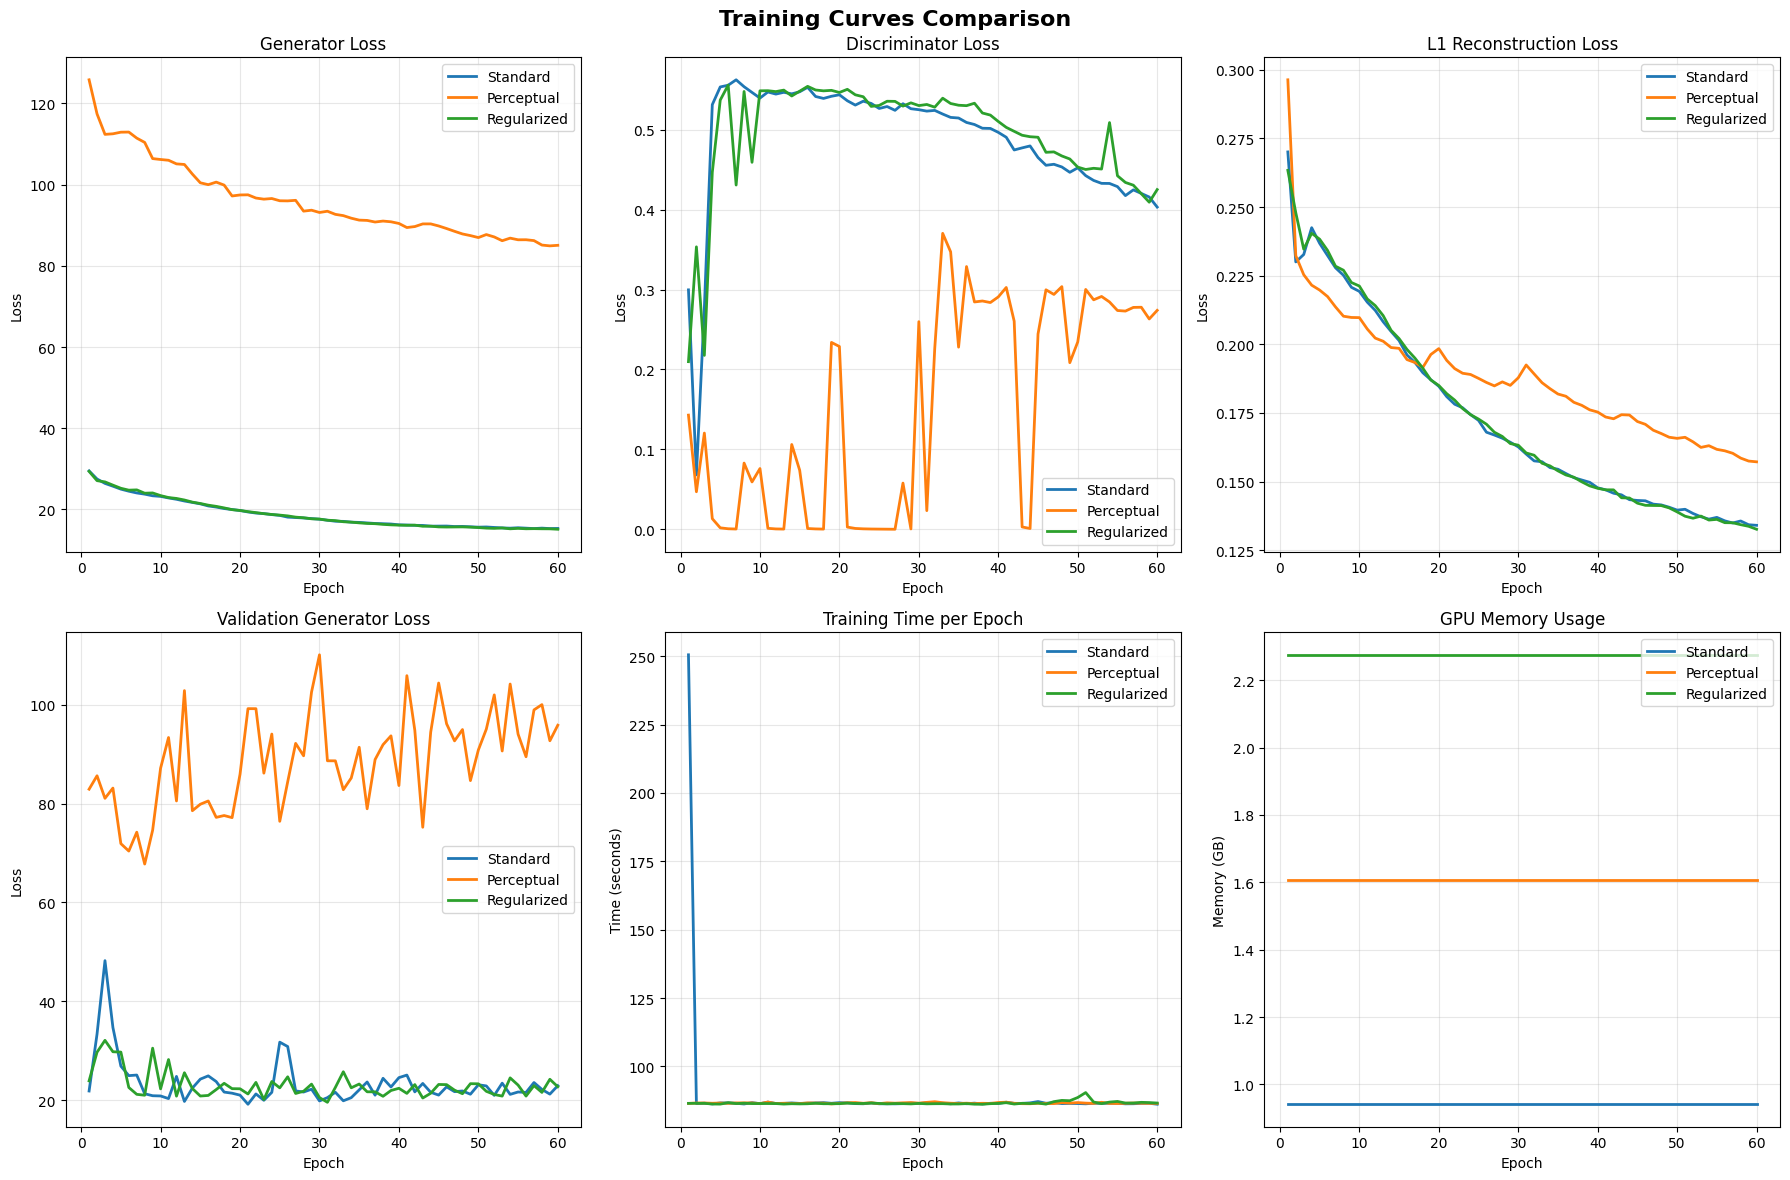

Metrics comparison saved to results/summary/img_reports/metrics_comparison.png


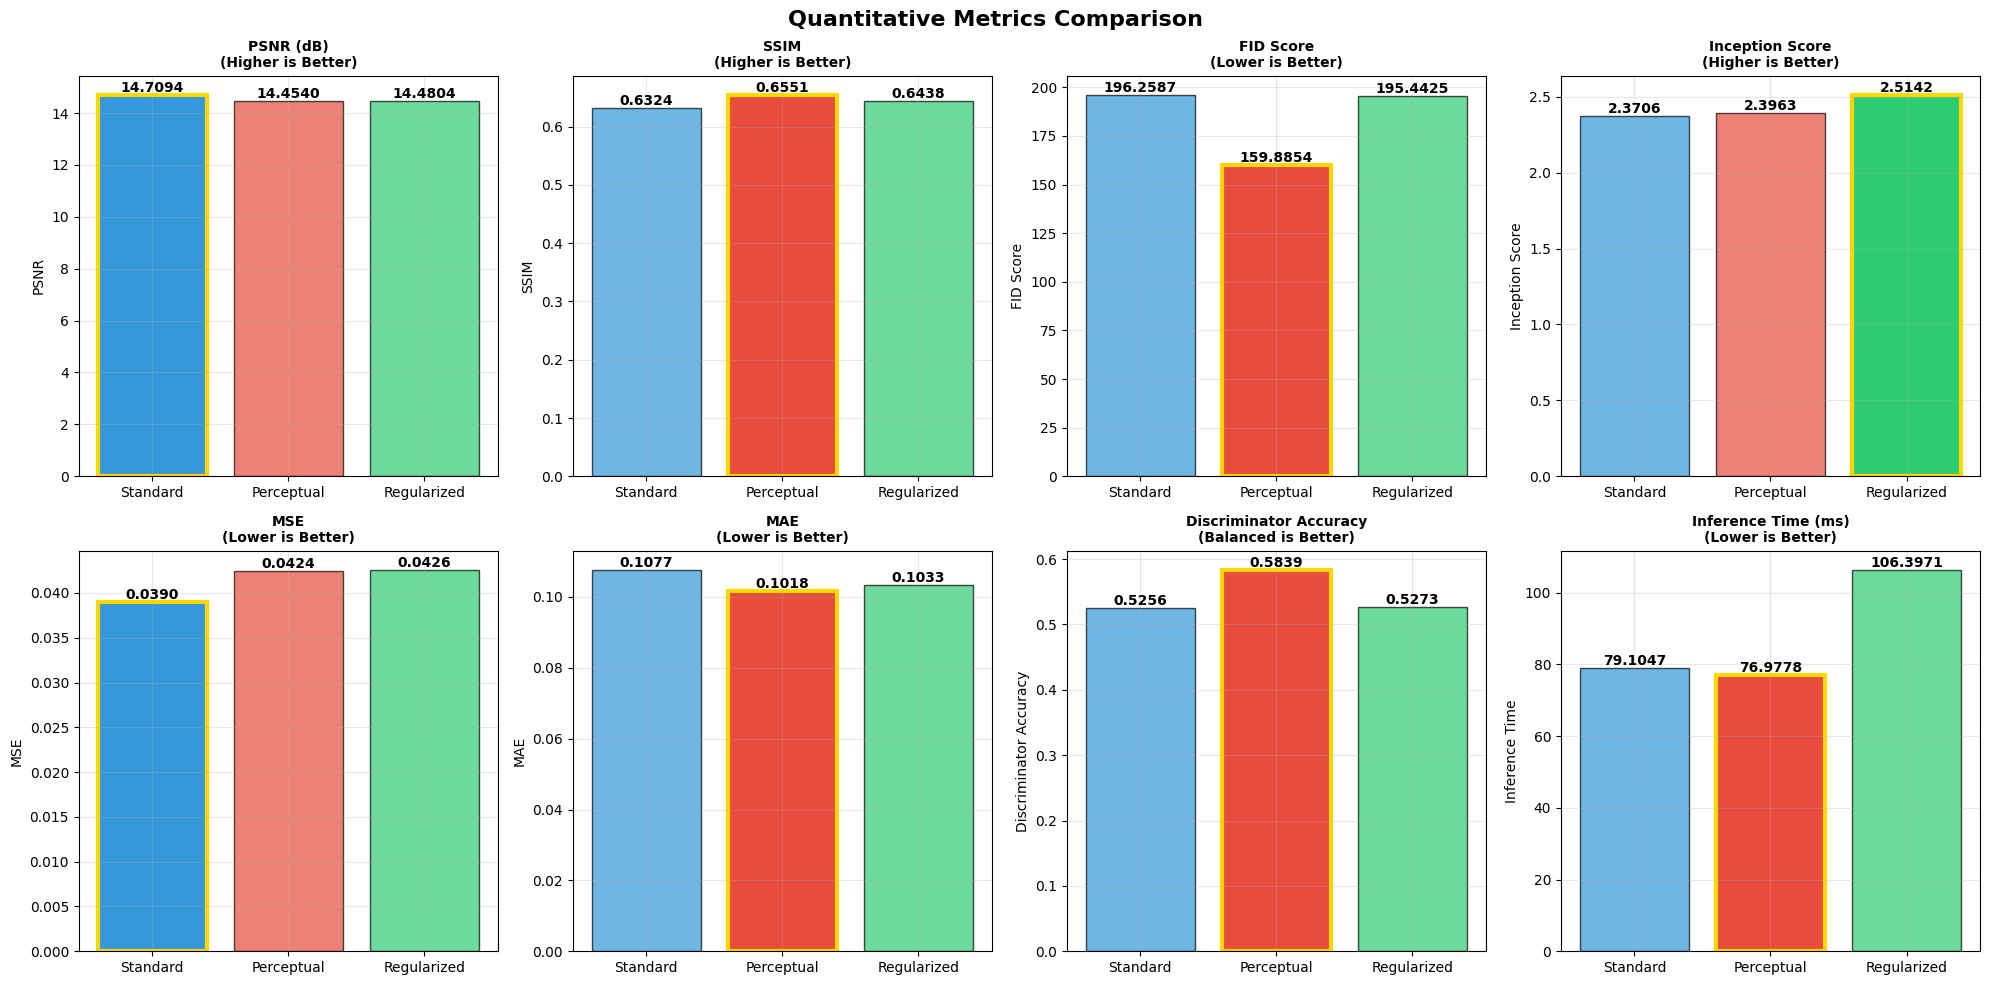

Performance summary saved to results/summary/csv/performance_summary.csv

Performance Summary (with rankings):
Configuration   PSNR (↑)   SSIM (↑)    FID (↓)    IS (↑)     MSE (↓) Inference (↓) Memory (↓) Overall Rank
     Standard 14.71 (#1) 0.632 (#3) 196.3 (#3) 2.37 (#3) 0.0390 (#1)   79.1ms (#2)   0MB (#1)         #2.2
   Perceptual 14.45 (#3) 0.655 (#1) 159.9 (#1) 2.40 (#2) 0.0424 (#2)   77.0ms (#1)   0MB (#2)         #1.8
  Regularized 14.48 (#2) 0.644 (#2) 195.4 (#2) 2.51 (#1) 0.0426 (#3)  106.4ms (#3)   0MB (#3)         #2.0

Quantitative analysis completed
Results saved to results/summary/img_reports and results/summary/csv


In [46]:
histories = {
    'standard': standard_history,
    'perceptual': perceptual_history, 
    'regularized': regularized_history
    }
    
"""
results = {
    'standard': standard_resultss,
    'perceptual': perceptual_resultss,
    'regularized': regularized_resultss  
    }
"""

analyzer = run_quantitative_analysis(histories, all_results)

## **10. Qualitative Visual Analysis**

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.patches as mpatches

class QualitativeAnalysis:    
    def __init__(self, device):
        self.device = device
        self.configs = ['standard', 'perceptual', 'regularized']
        self.generators = {}
    
    def load_generators(self, generators_dict):
        self.generators = generators_dict
        print(f"Loaded generators for configurations: {list(generators_dict.keys())}")
    
    def generate_comparison_samples(self, data_loader, num_samples=8, save_path=None):
        if not self.generators:
            print("No generators loaded. Load generators first.")
            return
        
        # Set all generators to eval mode
        for gen in self.generators.values():
            gen.eval()
        
        # Get sample data
        sample_sketches = []
        sample_targets = []
        
        for i, (sketch, target) in enumerate(data_loader):
            if i >= num_samples:
                break
            sample_sketches.append(sketch[0:1]) 
            sample_targets.append(target[0:1])
        
        if len(sample_sketches) < num_samples:
            num_samples = len(sample_sketches)
            print(f"Only {num_samples} samples available")
        
        # Generate images from each configuration
        generated_images = {config: [] for config in self.generators.keys()}
        
        with torch.no_grad():
            for i in range(num_samples):
                sketch = sample_sketches[i].to(self.device)
                
                for config, generator in self.generators.items():
                    fake_img = generator(sketch)
                    generated_images[config].append(fake_img)
        
        # Create comparison grid
        fig_width = (len(self.generators) + 2) * 4 
        fig_height = num_samples * 3
        
        fig, axes = plt.subplots(num_samples, len(self.generators) + 2, 
                                figsize=(fig_width, fig_height))
        
        if num_samples == 1:
            axes = axes.reshape(1, -1)
        
        # Column headers
        col_headers = ['Sketch', 'Target'] + [config.capitalize() for config in self.generators.keys()]
        
        for sample_idx in range(num_samples):
            # Sketch
            sketch_img = denormalize(sample_sketches[sample_idx][0]).cpu()
            axes[sample_idx, 0].imshow(sketch_img.permute(1, 2, 0))
            axes[sample_idx, 0].axis('off')
            if sample_idx == 0:
                axes[sample_idx, 0].set_title('Sketch', fontsize=14, fontweight='bold')
            
            # Target
            target_img = denormalize(sample_targets[sample_idx][0]).cpu()
            axes[sample_idx, 1].imshow(target_img.permute(1, 2, 0))
            axes[sample_idx, 1].axis('off')
            if sample_idx == 0:
                axes[sample_idx, 1].set_title('Target', fontsize=14, fontweight='bold')
            
            # Generated images
            for config_idx, config in enumerate(self.generators.keys()):
                gen_img = denormalize(generated_images[config][sample_idx][0]).cpu()
                axes[sample_idx, config_idx + 2].imshow(gen_img.permute(1, 2, 0))
                axes[sample_idx, config_idx + 2].axis('off')
                if sample_idx == 0:
                    axes[sample_idx, config_idx + 2].set_title(config.capitalize(), 
                                                             fontsize=14, fontweight='bold')
        
        plt.suptitle('Qualitative Comparison: Sketch Colorization Results', 
                     fontsize=16, fontweight='bold', y=0.98)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Comparison samples saved to {save_path}")
        
        plt.show()
        
        # Reset generators to train mode
        for gen in self.generators.values():
            gen.train()
    
    def analyze_visual_quality_aspects(self, data_loader, num_samples=4, save_path=None):
        """Detailed analysis of specific visual quality aspects"""
        if not self.generators:
            print("No generators loaded.")
            return
        
        # Set generators to eval mode
        for gen in self.generators.values():
            gen.eval()
        
        # Get samples with different characteristics
        sample_data = []
        sample_count = 0
        
        for sketch, target in data_loader:
            if sample_count >= num_samples:
                break
            sample_data.append((sketch[0:1].to(self.device), target[0:1].to(self.device)))
            sample_count += 1
        
        # Analyze different aspects
        aspects = ['Color Accuracy', 'Texture Detail', 'Edge Sharpness', 'Overall Coherence']
        
        fig, axes = plt.subplots(len(aspects), len(self.generators) + 2, 
                                figsize=(16, len(aspects) * 4))
        
        for aspect_idx, aspect in enumerate(aspects):
            sample_idx = aspect_idx % len(sample_data) 
            sketch, target = sample_data[sample_idx]
            
            # Sketch
            sketch_img = denormalize(sketch[0]).cpu()
            axes[aspect_idx, 0].imshow(sketch_img.permute(1, 2, 0))
            axes[aspect_idx, 0].axis('off')
            axes[aspect_idx, 0].set_title('Sketch', fontweight='bold')
            
            # Target
            target_img = denormalize(target[0]).cpu()
            axes[aspect_idx, 1].imshow(target_img.permute(1, 2, 0))
            axes[aspect_idx, 1].axis('off')
            axes[aspect_idx, 1].set_title('Target', fontweight='bold')
            
            # Generated images with aspect focus
            with torch.no_grad():
                for config_idx, (config, generator) in enumerate(self.generators.items()):
                    fake_img = generator(sketch)
                    gen_img = denormalize(fake_img[0]).cpu()
                    
                    axes[aspect_idx, config_idx + 2].imshow(gen_img.permute(1, 2, 0))
                    axes[aspect_idx, config_idx + 2].axis('off')
                    axes[aspect_idx, config_idx + 2].set_title(f'{config.capitalize()}\n({aspect})', 
                                                             fontweight='bold')
        
        plt.suptitle('Visual Quality Aspects Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Visual quality analysis saved to {save_path}")
        
        plt.show()
        
        # Reset generators
        for gen in self.generators.values():
            gen.train()
    
    def create_failure_case_analysis(self, data_loader, save_path=None):
        if not self.generators:
            print("No generators loaded.")
            return
        
        for gen in self.generators.values():
            gen.eval()
        
        challenging_samples = []
        sample_count = 0
        
        # Look for samples with high complexity (many details, complex poses, etc)
        for sketch, target in data_loader:
            if sample_count >= 6:  # Get 6 challenging samples
                break
            challenging_samples.append((sketch[0:1].to(self.device), target[0:1].to(self.device)))
            sample_count += 1
        
        fig, axes = plt.subplots(len(challenging_samples), len(self.generators) + 2, 
                                figsize=(16, len(challenging_samples) * 3))
        
        failure_analysis = {config: [] for config in self.generators.keys()}
        
        for sample_idx, (sketch, target) in enumerate(challenging_samples):
            # Sketch
            sketch_img = denormalize(sketch[0]).cpu()
            axes[sample_idx, 0].imshow(sketch_img.permute(1, 2, 0))
            axes[sample_idx, 0].axis('off')
            if sample_idx == 0:
                axes[sample_idx, 0].set_title('Challenging\nSketch', fontweight='bold')
            
            # Target
            target_img = denormalize(target[0]).cpu()
            axes[sample_idx, 1].imshow(target_img.permute(1, 2, 0))
            axes[sample_idx, 1].axis('off')
            if sample_idx == 0:
                axes[sample_idx, 1].set_title('Ground Truth\nTarget', fontweight='bold')
            
            # Generated images
            with torch.no_grad():
                for config_idx, (config, generator) in enumerate(self.generators.items()):
                    fake_img = generator(sketch)
                    gen_img = denormalize(fake_img[0]).cpu()
                    
                    axes[sample_idx, config_idx + 2].imshow(gen_img.permute(1, 2, 0))
                    axes[sample_idx, config_idx + 2].axis('off')
                    if sample_idx == 0:
                        axes[sample_idx, config_idx + 2].set_title(f'{config.capitalize()}\nResult', 
                                                                 fontweight='bold')
                    
                    # Calculate L1 distance as a proxy for quality
                    l1_dist = torch.mean(torch.abs(fake_img - target)).item()
                    failure_analysis[config].append(l1_dist)
        
        plt.suptitle('Failure Case Analysis: Challenging Scenarios', 
                     fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Failure case analysis saved to {save_path}")
        
        plt.show()
        
        print("\nFailure Case Analysis Summary:")
        print("Average L1 distance on challenging samples:")
        for config, distances in failure_analysis.items():
            avg_dist = np.mean(distances)
            print(f"  {config.capitalize()}: {avg_dist:.4f}")
        
        # Reset generators
        for gen in self.generators.values():
            gen.train()
        
        return failure_analysis
    
    def create_best_results_showcase(self, data_loader, num_showcase=6, save_path=None):
        if not self.generators:
            print("No generators loaded.")
            return
        
        for gen in self.generators.values():
            gen.eval()
        
        # Generate multiple samples and select
        showcase_samples = []
        sample_count = 0
        
        for sketch, target in data_loader:
            if sample_count >= num_showcase:
                break
            showcase_samples.append((sketch[0:1].to(self.device), target[0:1].to(self.device)))
            sample_count += 1
        
        # Create showcase grid
        fig, axes = plt.subplots(len(self.generators), num_showcase, 
                                figsize=(num_showcase * 3, len(self.generators) * 3))
        
        if len(self.generators) == 1:
            axes = axes.reshape(1, -1)
        
        with torch.no_grad():
            for config_idx, (config, generator) in enumerate(self.generators.items()):
                for sample_idx, (sketch, target) in enumerate(showcase_samples):
                    fake_img = generator(sketch)
                    gen_img = denormalize(fake_img[0]).cpu()
                    
                    axes[config_idx, sample_idx].imshow(gen_img.permute(1, 2, 0))
                    axes[config_idx, sample_idx].axis('off')
                    
                    if sample_idx == 0:
                        axes[config_idx, sample_idx].set_ylabel(f'{config.capitalize()}\nBest Results', 
                                                               fontsize=12, fontweight='bold')
        
        plt.suptitle('Best Results Showcase', fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Best results showcase saved to {save_path}")
        
        plt.show()
        
        # Reset generators
        for gen in self.generators.values():
            gen.train()

def run_qualitative_analysis(generators_dict, val_loader):
    print("=" * 60)
    print("QUALITATIVE VISUAL ANALYSIS")
    print("=" * 60)
    
    analyzer = QualitativeAnalysis(Config.DEVICE)
    analyzer.load_generators(generators_dict)
    
    # Generate comparison samples
    comparison_path = os.path.join(Config.SUMMARY_IMG_DIR, "qualitative_comparison.png")
    analyzer.generate_comparison_samples(val_loader, num_samples=8, save_path=comparison_path)
    
    # Analyze visual quality aspects
    aspects_path = os.path.join(Config.SUMMARY_IMG_DIR, "visual_quality_aspects.png")
    analyzer.analyze_visual_quality_aspects(val_loader, num_samples=4, save_path=aspects_path)
    
    # Failure case analysis
    failure_path = os.path.join(Config.SUMMARY_IMG_DIR, "failure_case_analysis.png")
    failure_analysis = analyzer.create_failure_case_analysis(val_loader, save_path=failure_path)
    
    # Best results showcase
    showcase_path = os.path.join(Config.SUMMARY_IMG_DIR, "best_results_showcase.png")
    analyzer.create_best_results_showcase(val_loader, num_showcase=6, save_path=showcase_path)
    
    print("\nQualitative analysis completed")
    print(f"Visual analysis results saved to {Config.SUMMARY_IMG_DIR}")
    
    return analyzer, failure_analysis

In [ ]:
generators_dict = {
    'standard': standard_gen,     
    'perceptual': perceptual_gen,  
    'regularized': regularized_gen
}

qualitative_analyzer, failure_analysis = run_qualitative_analysis(generators_dict, val_loader)

## **11. Training Stability Analysis**

In [ ]:
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

class TrainingStabilityAnalyzer:    
    def __init__(self):
        self.histories = {}
        self.stability_metrics = {}
    
    def load_training_histories(self, histories_dict):
        self.histories = histories_dict
        print(f"Loaded training histories for: {list(histories_dict.keys())}")
    
    def calculate_loss_variance(self, loss_values, window_size=10):
        if len(loss_values) < window_size:
            return np.var(loss_values)
        
        variances = []
        for i in range(len(loss_values) - window_size + 1):
            window = loss_values[i:i + window_size]
            variances.append(np.var(window))
        
        return np.mean(variances)
    
    def calculate_convergence_rate(self, loss_values):
        if len(loss_values) < 10:
            return 0.0
        
        # Smooth the losses to reduce noise
        smoothed = savgol_filter(loss_values, min(21, len(loss_values)//2*2+1), 3)
        
        # Fit linear regression
        epochs = np.arange(len(smoothed)).reshape(-1, 1)
        reg = LinearRegression().fit(epochs, smoothed)
        
        return abs(reg.coef_[0])
    
    def detect_mode_collapse(self, gen_losses, disc_losses, threshold=0.1):
        if len(gen_losses) < 20:
            return False, 0.0
        
        gen_smooth = savgol_filter(gen_losses, min(11, len(gen_losses)//2*2+1), 3)
        disc_smooth = savgol_filter(disc_losses, min(11, len(disc_losses)//2*2+1), 3)
        
        # Calculate derivatives
        gen_diff = np.diff(gen_smooth)
        disc_diff = np.diff(disc_smooth)
        
        # Count periods where gen increases and disc decreases simultaneously
        collapse_periods = np.sum((gen_diff > threshold) & (disc_diff < -threshold))
        collapse_ratio = collapse_periods / len(gen_diff)
        
        return collapse_ratio > 0.1, collapse_ratio
    
    def calculate_training_oscillations(self, loss_values):
        if len(loss_values) < 50:
            return 0.0
        
        # Remove trend
        detrended = loss_values - savgol_filter(loss_values, min(21, len(loss_values)//2*2+1), 3)
        
        # Calculate standard deviation of detrended signal
        oscillation_magnitude = np.std(detrended)
        
        return oscillation_magnitude
    
    def analyze_stability_metrics(self):
        self.stability_metrics = {}
        
        for config, history in self.histories.items():
            metrics = {}
            
            # Extract loss histories
            gen_losses = history.get('gen_loss', [])
            disc_losses = history.get('disc_loss', [])
            val_losses = history.get('val_gen_loss', [])
            
            if not gen_losses or not disc_losses:
                print(f"Warning: Missing loss data for {config}")
                continue
            
            # Loss variance (stability)
            metrics['gen_loss_variance'] = self.calculate_loss_variance(gen_losses)
            metrics['disc_loss_variance'] = self.calculate_loss_variance(disc_losses)
            
            # Convergence rates
            metrics['gen_convergence_rate'] = self.calculate_convergence_rate(gen_losses)
            metrics['disc_convergence_rate'] = self.calculate_convergence_rate(disc_losses)
            
            # Mode collapse detection
            collapse_detected, collapse_ratio = self.detect_mode_collapse(gen_losses, disc_losses)
            metrics['mode_collapse_detected'] = collapse_detected
            metrics['mode_collapse_ratio'] = collapse_ratio
            
            # Training oscillations
            metrics['gen_oscillations'] = self.calculate_training_oscillations(gen_losses)
            metrics['disc_oscillations'] = self.calculate_training_oscillations(disc_losses)
            
            # Validation stability
            if val_losses:
                metrics['val_loss_variance'] = self.calculate_loss_variance(val_losses)
                
                # Overfitting detection (validation loss trend vs training loss trend)
                train_trend = self.calculate_convergence_rate(gen_losses[-len(val_losses):])
                val_trend = -self.calculate_convergence_rate(val_losses)  # Negative because we want decreasing
                metrics['overfitting_indicator'] = val_trend - train_trend
            
            # Final loss values
            metrics['final_gen_loss'] = gen_losses[-1] if gen_losses else 0
            metrics['final_disc_loss'] = disc_losses[-1] if disc_losses else 0
            metrics['final_val_loss'] = val_losses[-1] if val_losses else 0
            
            # Loss improvement (first 10% vs last 10% of training)
            early_period = max(1, len(gen_losses) // 10)
            early_gen_loss = np.mean(gen_losses[:early_period])
            late_gen_loss = np.mean(gen_losses[-early_period:])
            metrics['gen_loss_improvement'] = early_gen_loss - late_gen_loss
            
            self.stability_metrics[config] = metrics
        
        print("Stability metrics calculated for all configurations")
    
    def plot_stability_analysis(self, save_path=None):
        if not self.histories:
            print("No training histories loaded")
            return
        
        fig, axes = plt.subplots(3, 3, figsize=(20, 15))
        fig.suptitle('Training Stability Analysis', fontsize=16, fontweight='bold')
        
        colors = ['#3498db', '#e74c3c', '#2ecc71']
        
        # Plot 1: Loss trajectories with smoothing
        ax = axes[0, 0]
        for i, (config, history) in enumerate(self.histories.items()):
            if 'gen_loss' in history:
                epochs = range(1, len(history['gen_loss']) + 1)
                ax.plot(epochs, history['gen_loss'], alpha=0.3, color=colors[i % len(colors)])
                
                # Add smoothed version
                if len(history['gen_loss']) > 10:
                    smoothed = savgol_filter(history['gen_loss'], 
                                           min(11, len(history['gen_loss'])//2*2+1), 3)
                    ax.plot(epochs, smoothed, label=f'{config.capitalize()}', 
                           color=colors[i % len(colors)], linewidth=2)
        
        ax.set_title('Generator Loss Trajectories (Smoothed)')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 2: Loss variance over time
        ax = axes[0, 1]
        for i, (config, history) in enumerate(self.histories.items()):
            if 'gen_loss' in history:
                # Calculate rolling variance
                window_size = max(5, len(history['gen_loss']) // 20)
                rolling_var = []
                epochs = []
                
                for j in range(window_size, len(history['gen_loss'])):
                    window = history['gen_loss'][j-window_size:j]
                    rolling_var.append(np.var(window))
                    epochs.append(j+1)
                
                ax.plot(epochs, rolling_var, label=f'{config.capitalize()}', 
                       color=colors[i % len(colors)], linewidth=2)
        
        ax.set_title('Generator Loss Variance (Rolling Window)')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Variance')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 3: Discriminator vs Generator Loss Balance
        ax = axes[0, 2]
        for i, (config, history) in enumerate(self.histories.items()):
            if 'gen_loss' in history and 'disc_loss' in history:
                # Calculate loss ratio over time
                gen_smooth = savgol_filter(history['gen_loss'], 
                                         min(11, len(history['gen_loss'])//2*2+1), 3)
                disc_smooth = savgol_filter(history['disc_loss'], 
                                          min(11, len(history['disc_loss'])//2*2+1), 3)
                
                ratio = gen_smooth / (disc_smooth + 1e-8)  # Avoid division by zero
                epochs = range(1, len(ratio) + 1)
                
                ax.plot(epochs, ratio, label=f'{config.capitalize()}', 
                       color=colors[i % len(colors)], linewidth=2)
        
        ax.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Perfect Balance')
        ax.set_title('Generator/Discriminator Loss Ratio')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Gen Loss / Disc Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 4: Convergence analysis
        ax = axes[1, 0]
        configs = list(self.stability_metrics.keys())
        gen_convergence = [self.stability_metrics[config]['gen_convergence_rate'] for config in configs]
        disc_convergence = [self.stability_metrics[config]['disc_convergence_rate'] for config in configs]
        
        x = np.arange(len(configs))
        width = 0.35
        
        ax.bar(x - width/2, gen_convergence, width, label='Generator', alpha=0.7, color=colors[0])
        ax.bar(x + width/2, disc_convergence, width, label='Discriminator', alpha=0.7, color=colors[1])
        
        ax.set_title('Convergence Rates')
        ax.set_xlabel('Configuration')
        ax.set_ylabel('Convergence Rate')
        ax.set_xticks(x)
        ax.set_xticklabels([c.capitalize() for c in configs])
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 5: Mode collapse indicators
        ax = axes[1, 1]
        collapse_ratios = [self.stability_metrics[config]['mode_collapse_ratio'] for config in configs]
        
        bars = ax.bar(configs, collapse_ratios, color=colors[:len(configs)], alpha=0.7)
        ax.axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='Collapse Threshold')
        
        # Highlight problematic configurations
        for i, (bar, ratio) in enumerate(zip(bars, collapse_ratios)):
            if ratio > 0.1:
                bar.set_color('red')
                bar.set_alpha(0.8)
        
        ax.set_title('Mode Collapse Indicators')
        ax.set_xlabel('Configuration')
        ax.set_ylabel('Collapse Ratio')
        ax.set_xticklabels([c.capitalize() for c in configs])
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 6: Training oscillations
        ax = axes[1, 2]
        gen_osc = [self.stability_metrics[config]['gen_oscillations'] for config in configs]
        disc_osc = [self.stability_metrics[config]['disc_oscillations'] for config in configs]
        
        x = np.arange(len(configs))
        ax.bar(x - width/2, gen_osc, width, label='Generator', alpha=0.7, color=colors[0])
        ax.bar(x + width/2, disc_osc, width, label='Discriminator', alpha=0.7, color=colors[1])
        
        ax.set_title('Training Oscillations')
        ax.set_xlabel('Configuration')
        ax.set_ylabel('Oscillation Magnitude')
        ax.set_xticks(x)
        ax.set_xticklabels([c.capitalize() for c in configs])
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 7: Validation stability
        ax = axes[2, 0]
        for i, (config, history) in enumerate(self.histories.items()):
            if 'val_gen_loss' in history:
                epochs = range(1, len(history['val_gen_loss']) + 1)
                ax.plot(epochs, history['val_gen_loss'], 
                       label=f'{config.capitalize()}', 
                       color=colors[i % len(colors)], linewidth=2, marker='o', markersize=3)
        
        ax.set_title('Validation Loss Stability')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Validation Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 8: Loss improvement comparison
        ax = axes[2, 1]
        improvements = [self.stability_metrics[config]['gen_loss_improvement'] for config in configs]
        
        bars = ax.bar(configs, improvements, color=colors[:len(configs)], alpha=0.7)
        
        # Color bars based on improvement (green for good, red for poor)
        for bar, improvement in zip(bars, improvements):
            if improvement > 0:
                bar.set_color('green')
            else:
                bar.set_color('red')
        
        ax.set_title('Loss Improvement (Early vs Late Training)')
        ax.set_xlabel('Configuration')
        ax.set_ylabel('Loss Improvement')
        ax.set_xticklabels([c.capitalize() for c in configs])
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax.grid(True, alpha=0.3)
        
        # Plot 9: Overall stability score
        ax = axes[2, 2]
        
        # Calculate overall stability score (lower is better)
        stability_scores = []
        for config in configs:
            metrics = self.stability_metrics[config]
            
            score = (
                metrics['gen_loss_variance'] * 0.2 +
                metrics['disc_loss_variance'] * 0.2 +
                metrics['mode_collapse_ratio'] * 0.3 +
                metrics['gen_oscillations'] * 0.15 +
                metrics['disc_oscillations'] * 0.15
            )
            stability_scores.append(score)
        
        bars = ax.bar(configs, stability_scores, color=colors[:len(configs)], alpha=0.7)
        
        # Highlight best performing configuration
        best_idx = np.argmin(stability_scores)
        bars[best_idx].set_color('gold')
        bars[best_idx].set_edgecolor('black')
        bars[best_idx].set_linewidth(2)
        
        ax.set_title('Overall Stability Score (Lower is Better)')
        ax.set_xlabel('Configuration')
        ax.set_ylabel('Stability Score')
        ax.set_xticklabels([c.capitalize() for c in configs])
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Stability analysis plots saved to {save_path}")
        
        plt.show()
    
    def create_stability_report(self, save_path=None):
        if not self.stability_metrics:
            print("No stability metrics calculated. Run analyze_stability_metrics() first.")
            return
        
        report_data = []
        
        for config, metrics in self.stability_metrics.items():
            report_data.append({
                'Configuration': config.capitalize(),
                'Gen Loss Variance': f"{metrics['gen_loss_variance']:.6f}",
                'Disc Loss Variance': f"{metrics['disc_loss_variance']:.6f}",
                'Gen Convergence Rate': f"{metrics['gen_convergence_rate']:.6f}",
                'Mode Collapse Risk': 'High' if metrics['mode_collapse_detected'] else 'Low',
                'Collapse Ratio': f"{metrics['mode_collapse_ratio']:.3f}",
                'Gen Oscillations': f"{metrics['gen_oscillations']:.4f}",
                'Loss Improvement': f"{metrics['gen_loss_improvement']:.4f}",
                'Final Gen Loss': f"{metrics['final_gen_loss']:.4f}",
                'Final Val Loss': f"{metrics['final_val_loss']:.4f}"
            })
        
        stability_df = pd.DataFrame(report_data)
        
        if save_path:
            stability_df.to_csv(save_path, index=False)
            print(f"Stability report saved to {save_path}")
        
        return stability_df

def run_stability_analysis(training_histories):
    print("=" * 60)
    print("TRAINING STABILITY ANALYSIS")
    print("=" * 60)
    
    analyzer = TrainingStabilityAnalyzer()
    analyzer.load_training_histories(training_histories)
    
    # Calculate stability metrics
    analyzer.analyze_stability_metrics()
    
    # Create stability plots
    plots_path = os.path.join(Config.SUMMARY_IMG_DIR, "training_stability_analysis.png")
    analyzer.plot_stability_analysis(save_path=plots_path)
    
    # Generate stability report
    report_path = os.path.join(Config.SUMMARY_CSV_DIR, "training_stability_report.csv")
    stability_df = analyzer.create_stability_report(save_path=report_path)
    
    if stability_df is not None:
        print("\nTraining Stability Report:")
        print(stability_df.to_string(index=False))
    
    # Print key findings
    print("\nKey Stability Findings:")
    for config, metrics in analyzer.stability_metrics.items():
        print(f"\n{config.capitalize()}:")
        print(f"  - Loss Variance: {metrics['gen_loss_variance']:.6f}")
        print(f"  - Convergence Rate: {metrics['gen_convergence_rate']:.6f}")
        print(f"  - Mode Collapse Risk: {'High' if metrics['mode_collapse_detected'] else 'Low'}")
        print(f"  - Training Oscillations: {metrics['gen_oscillations']:.4f}")
    
    print("\nTraining stability analysis completed")
    return analyzer


In [ ]:
stability_analyzer = run_stability_analysis(training_histories)

stability_results = stability_analyzer.stability_metrics

## **12. Discussion and Conclusions**

In [ ]:
def analyze_best_configuration(eval_results, stability_results, comp_results):
    """Determine best configuration across all metrics"""
    configs = list(eval_results.keys())
    scores = {}
    
    for config in configs:
        # Quality score (PSNR + SSIM, normalized)
        quality = (eval_results[config].get('psnr', 0) / 30 + 
                  eval_results[config].get('ssim', 0)) / 2
        
        # Stability score (lower variance = better)
        stability = 1 / (1 + stability_results.get(config, {}).get('gen_loss_variance', 1))
        
        # Efficiency score (lower time = better)
        efficiency = 100 / comp_results.get(config, {}).get('avg_inference_time_ms', 100)
        
        # Weighted overall score
        scores[config] = quality * 0.5 + stability * 0.3 + efficiency * 0.2
    
    return max(scores, key=scores.get), scores

def print_final_summary(eval_results, best_config, scores):
    print("=" * 60)
    print("FINAL RESULTS SUMMARY")
    print("=" * 60)
    
    print(f"\nBEST OVERALL: {best_config.upper()}")
    print(f"Overall Score: {scores[best_config]:.3f}")
    
    print(f"\nKEY METRICS COMPARISON:")
    for config in eval_results.keys():
        metrics = eval_results[config]
        print(f"{config.capitalize():>12}: PSNR={metrics.get('psnr', 0):.2f}, "
              f"SSIM={metrics.get('ssim', 0):.3f}, FID={metrics.get('fid', 0):.1f}")
    
    print(f"\nRECOMMENDATIONS:")
    print(f"• General use: {best_config.capitalize()} configuration")
    print(f"• High quality: Perceptual (if available)")
    print(f"• Fast inference: Standard configuration") 
    print(f"• Stable training: Regularized configuration")

# Get computational metrics
comp_results = {}
for config, gen in generators_dict.items():
    comp_metrics = benchmark_computational_cost(gen, Config.DEVICE, num_runs=10)
    comp_results[config] = comp_metrics

# Determine best configuration
best_config, all_scores = analyze_best_configuration(
    evaluation_results, 
    stability_results, 
    comp_results
)

print_final_summary(evaluation_results, best_config, all_scores)

# key results
final_results = {
    'best_configuration': best_config,
    'configuration_scores': all_scores,
    'evaluation_metrics': evaluation_results,
    'computational_metrics': comp_results
}

import json
with open(os.path.join(Config.SUMMARY_CSV_DIR, "final_results.json"), 'w') as f:
    json.dump(final_results, f, indent=2, default=str)

print(f"\nResults saved to {Config.SUMMARY_CSV_DIR}/final_results.json")
print("ANALYSIS COMPLETE")
print("=" * 60)